In [1]:
from basiss.pile_of_code import *

## Sample load

In [2]:
with open('../pymc_model/data/newdata_saved.pkl', 'rb') as file:
    saved_lists = pkl.load(file)
imm_sample_list = saved_lists['imm_sample_list']
exp_sample_list = saved_lists['exp_sample_list']
mut_sample_list = saved_lists['mut_sample_list']
val_sample_list = saved_lists['val_sample_list']

## Construct model data

#### Loading genotype matrix (tree)

The genotype matrix $\mathbf{G}$ contains the number of each allelic copy in each clone $s$. $\mathbf{G}$ is a matrix representation of the underlying phylogenetic tree and provides the instructions of the allelic configuration in each branch of the tree.

In [3]:
#loading tree 
genes_to_drop = []
tree = pd.read_csv('./data/PD9694_tree.csv', index_col=0)


In [4]:
#adding 2 wt classes
M = np.array(tree.iloc[:-1])
M_wt = np.array(tree.iloc[-1])
n_wt=2
M = np.concatenate([M] + n_wt * [M_wt[None,:]],axis=0)


#### Calculating VAF data from WGS  

WGS data contains information of the mutated allele frequencies on the whole slide. We can use this data to better regularise the model

We construct a Beta pseudo-likelihood of $\mathbf{VAF}^{\text{BaSISS}}$ with $\alpha$ and $\beta$ parameters proprtional to the number of mutated and wild-type reads in WGS experiment. We use parameter $u=5$ to inflate uncertainty in WGS data as it comes from proximal but not exactly the same slide we are observing in BaSISS experiment. 

$$\text{VAF}^{\text{BaSISS}}_m \sim \mathrm{Beta}(\alpha=\text{WGS}^\text{mut}_m / u + 1, \alpha=\text{WGS}^\text{wt}_m / u + 1)$$

In [5]:
wgs_data = pd.read_csv('./data/PD9694_genome_data_dec_2020.csv')
wgs_data = wgs_data[np.logical_not(np.isin(wgs_data.ISS_id,genes_to_drop))]
wgs_names = np.array(wgs_data.ISS_id)
wgs_names[np.where(wgs_names=='AP3B2')[0]] = 'AP3B22'
wgs_wt = []
wgs_mut = []
for i, s in enumerate('dac'):
    wgs_mut.append(np.array(wgs_data[f'VAL_MtAll_PD9694{s}'] + wgs_data[f'DIS_MtAll_PD9694{s}']))
    wgs_wt.append(np.array(wgs_data[f'VAL_sample_PD9694{s}_depth'] + wgs_data[f'DIS_sample_PD9694{s}_depth'] - (wgs_data[f'VAL_MtAll_PD9694{s}'] + wgs_data[f'DIS_MtAll_PD9694{s}'])))

# for samples without WGS data we use those of sample D (also DCIS)
wgs_wt.append(wgs_wt[0]/5)
wgs_mut.append(wgs_mut[0]/5)
wgs_wt.append(wgs_wt[0]/5)
wgs_mut.append(wgs_mut[0]/5)

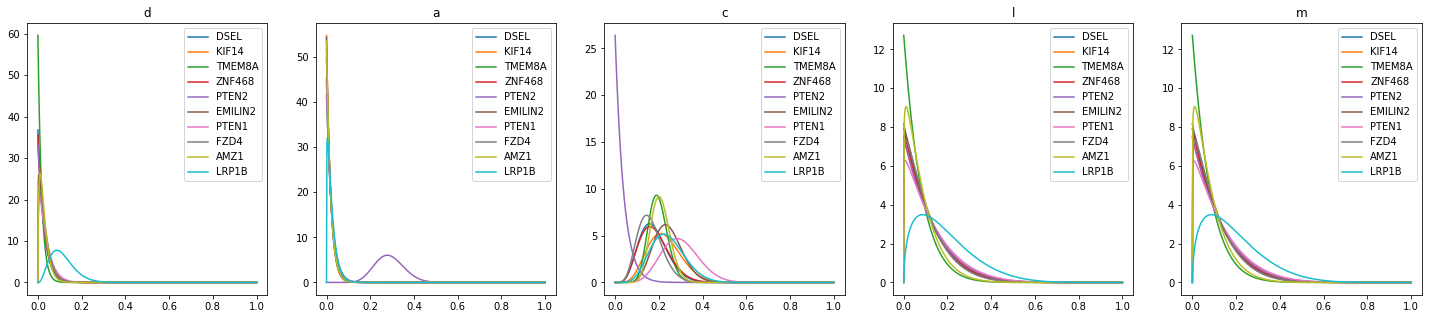

In [6]:
plt.figure(figsize=(25,5))
for s in range(5):
    plt.subplot(1,5,s+1)
    for i in range(10):#len(wgs_names)):
        plt.plot(np.linspace(0.0,1,500), stats.beta(wgs_mut[s][i]/5 + 1, wgs_wt[s][i]/5+1).pdf(np.linspace(0.0,1,500)), label=wgs_names[i])
        #plt.ylim(0,100)
        plt.legend()
        plt.rcParams['figure.facecolor'] = 'w'
    plt.title('daclm'[s])

The counts of all probes can be represented by a three dimensional array $\mathbf{D} \in \mathbb{N}^{|a|\times |x| \times |y|}$, where $a$ refers to the allele and $x$ and $y$ are course grained coordinates on a regular grid of dimensions $|x| \times |y|$. The grid size was chosen to be  108.8$\mu$m considering a trade-off between data sparsity, precision and computational cost.

In [7]:
scale = 3

mut_mask = mask_infisble(mut_sample_list, scale, probability=0.6, plot=False)
data4model = generate_data4model(samples_list=mut_sample_list, genes=tree.columns, M=M, n_aug=1)

n_samples = data4model['n_samples']
n_genes = data4model['n_genes']
iss_data = data4model['iss_data']
tiles_axes = data4model['tiles_axes']
cells_counts = data4model['cells_counts']
sample_dims = data4model['sample_dims']
n_factors = data4model['n_factors']
n_aug = data4model['n_aug']

mask = mut_mask

100%|██████████| 56/56 [00:00<00:00, 262.46it/s]


### Define and run model

The essential idea is that the expected number of BaSISS signals is decomposed into maps of $|s|$ distinct clones $s$ $\mathbf{M} \in \mathbb{R}^{|s|\times |x| \times |y|}$ each with a distinct genotype $\mathbf{G} \in \mathbb{N}^{|a|\times |s|}$,

$$\mathbb{E}[\mathbf{D}] \approx \mathbf{G} \times \mathbf{M} = \sum_{s \in \text{subclones}} \mathbf{G}_{\cdot, s} \mathbf{M}_{s, \cdot, \cdot}$$

Accounting for sources of noise, this equation for the expected number of BaSISS signals becomes:


$$\boldsymbol{\mu}_{a, x,y} = \underbrace{\boldsymbol{\nu}_{x,y}}_{\text{cell density}} \cdot \overbrace{\boldsymbol{\iota}_a}^{ {\text{detection rate}}} \cdot \underbrace{\sum_{a'} \boldsymbol{\tau}_{a,a'}}_{\text{probe confusion}} \sum_s  \overbrace{\boldsymbol{\gamma}_{s,a}}^{ {\text{clone-specific expression}}} \underbrace{\mathbf{G}_{a,s} \mathbf{M}_{s,x,y}}_{\text{clone contribution}} + \overbrace{\boldsymbol{\beta}_a}^{ {\text{background}}}$$

For more detials see Suppl. Methods 

In [ ]:
with pm.Model() as model_hierarchical_errosion:
    
    xi = [pm.Gamma('xi_{}'.format(s), mu=0.5, sigma=1, shape=n_genes) for s in range(n_samples)]
    r_mu = pm.Gamma('r', mu=0.5, sigma=1, shape=n_genes)
    r_de = [pm.Lognormal('r_de_{}'.format(s), mu=0, sigma=0.05, shape=n_genes) for s in range(n_samples)]
    r = [r_mu * r_de_i for r_de_i in r_de]
    
    cov_func1_f = [[pm.gp.cov.ExpQuad(1, ls=2.5*np.sqrt(scale)) for i in range(n_factors-1 + n_aug)] for s in range(n_samples)]
    cov_func2_f = [[pm.gp.cov.ExpQuad(1, ls=2.5*np.sqrt(scale))  for i in range(n_factors-1 + n_aug)] for s in range(n_samples)]

    gp_f = [[pm.gp.LatentKron(cov_funcs=[cov_func1_f[s][i], cov_func2_f[s][i]]) for i in range(n_factors - 1 + n_aug)] for s in range(n_samples)] 
    f_f = [[gp_f[s][i].prior(name, Xs=tiles_axes[s]) for i, name in enumerate(['f_f_{}_{}'.format(i, s) for i in range(n_factors - 1 + n_aug)])] for s in range(n_samples)]
    f_f = [f_f[s] + [np.ones(len(cells_counts[s]))*(-1.7)] for s in range(n_samples)]
    F_matrix = [tt.stack(f_f[s], axis=1) for s in range(n_samples)]

    F = [pm.Deterministic('F_{}'.format(s), tt.exp(F_matrix[s] / 2) / tt.exp(F_matrix[s] / 2).sum(axis=1)[:,None]) for s in range(n_samples)]

    lm_n = [pm.Gamma('lm_n_{}'.format(s), mu=50, sigma=100, shape=len(cells_counts[s])) for s in range(n_samples)]
    pois_n = [pm.Poisson('n_{}'.format(s), lm_n[s], observed=cells_counts[s]) for s in range(n_samples)]  

    
    E0 = 4 # ie 1 for most loci; 4 for amps
    E = [E0 * pm.Beta(f'E_{s}',0.01,1, shape=(n_aug, n_genes)) for s in range(n_samples)] 
    
    M_de = pm.Lognormal('M_de', mu=0.0, sigma=0.05, shape=M.shape)    
    M_de = tt.pow(M_de, tt.concatenate([tt.ones((n_factors-n_wt,1)), 2 * tt.ones((n_wt,1))],axis=0))
    M_aug = M * M_de
    M_aug_de = [pm.Lognormal(f'M_aug_{s}', mu=0.0, sigma=0.05, shape=(n_factors, n_genes)) for s in range(n_samples)]

    
    theta_pure = [pm.Deterministic('theta_{}'.format(s), tt.dot(F[s], tt.concatenate([M,E[s]]))) for s in range(n_samples)]
    
    theta = [pm.Deterministic('theta_mod_{}'.format(s), tt.dot(F[s], tt.concatenate([M_aug * M_aug_de[s] , E[s]], axis=0))) for s in range(n_samples)] #* M_aug_de[s]

   
    z = 1 - pm.Beta('z', 1, 25, shape=n_genes)/4 ## ie ~1% probe confusion
    
    confusion_matrix = tt.eye(n_genes)

    for i in range(n_genes):
        for j in range(n_genes):
            if tree.columns[i].endswith('mut') and tree.columns[j].endswith('mut') and tree.columns[i][:-3] == tree.columns[j][:-3]:
                confusion_matrix = tt.set_subtensor(confusion_matrix[i, j], z[i])
    
            if tree.columns[i].endswith('wt') and tree.columns[j].endswith('wt') and tree.columns[i][:-2] == tree.columns[j][:-2]:
                confusion_matrix = tt.set_subtensor(confusion_matrix[i, j], z[i])#
    
            if tree.columns[i][:-3] == tree.columns[j][:-2]:
                confusion_matrix = tt.set_subtensor(confusion_matrix[i, j], 1-z[i])#
    
            if tree.columns[i][:-2] == tree.columns[j][:-3]:
                confusion_matrix = tt.set_subtensor(confusion_matrix[i, j], 1-z[i])

    
    lm = [theta[s]  * lm_n[s][:, None] * r[s][None,:] for s in range(n_samples)]
    
    
    T = [tt.dot(F[s].sum(axis=0), tt.concatenate([M, E[s]], axis=0)) for s in range(n_samples)] ## Just sum actual genotypes
    T_freq = [T[s][[np.where(tree.columns == gene + 'mut')[0][0] for gene in wgs_names]] \
              / (T[s][[np.where(tree.columns == gene + 'wt')[0][0] for gene in wgs_names]] \
                 + T[s][[np.where(tree.columns == gene + 'mut')[0][0] for gene in wgs_names]]) for s in range(n_samples)]
    
    beta_prior = [Beta_sum('beta_prior_{}'.format(s), n=(mask[s].sum()), alpha=(wgs_mut[s]/5 + 1), beta=(wgs_wt[s]/5 + 1), observed=T_freq[s][:]) for s in range(n_samples)]
    


    lm_er = [pm.Deterministic('lm_er_{}'.format(s), tt.dot(lm[s], confusion_matrix) + xi[s][None,:]) for s in range(n_samples)]
    
    o = pm.Gamma('o', mu=100, sd=10, shape=n_genes)

    signal = [pm.NegativeBinomial('exp_{}'.format(s), mu = lm_er[s][mask[s],:], alpha=o, observed=iss_data[s][mask[s],:]) for s in range(n_samples)]


In [ ]:
np.random.seed(1234)
pm.set_tt_rng(1234)

with model_hierarchical_errosion :
    advi = pm.ADVI()
    approx_hierarchical_errosion = advi.fit(n=15000, obj_optimizer=pm.adam(learning_rate=0.01))
    #approx_hierarchical_errosion = advi.fit(n=2000, obj_optimizer=pm.adam(learning_rate=0.01))
    


In [ ]:
plt.plot(approx_hierarchical_errosion.hist[1000:])
samples_hierarchical_errosion = approx_hierarchical_errosion.sample(300)


In [8]:
#save/load model

#with open('./data/model_2805_final_30-01.pkl', 'wb') as file:
#    pkl.dump(samples_hierarchical_errosion, file)

with open('../pymc_model/data/model_2805_final_30-01.pkl', 'rb') as file:
    samples_hierarchical_errosion = pkl.load(file)

### Display fields 

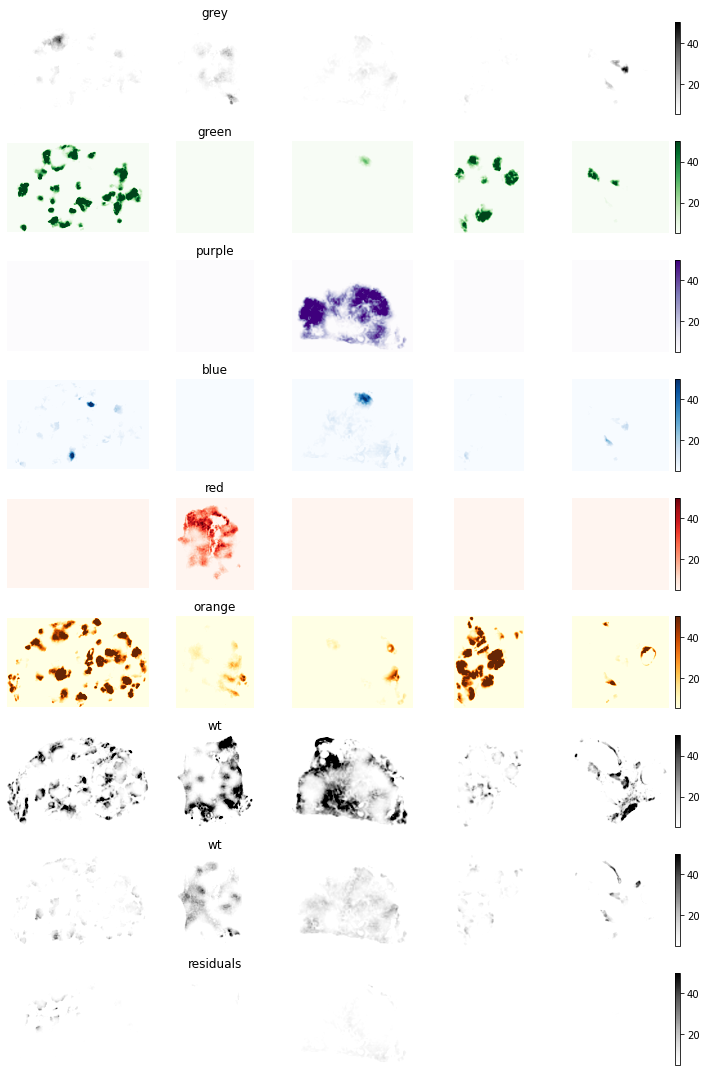

In [9]:
from matplotlib.colors import ListedColormap

alphas = np.concatenate((np.abs(np.linspace(0, 0, 256 - 200)), np.abs(np.linspace(0, 1.0, 256 - 56))))
N = 256

vals = np.ones((N, 4))
vals[:, 0] = np.linspace(1, 240/256, N)
vals[:, 1] = np.linspace(1, 228/256, N)
vals[:, 2] = np.linspace(1, 66/256, N)
vals[:, 3] = alphas
YellowCM = ListedColormap(vals)

plt.figure(figsize=(20/2, 30/2))
c = 0
#names = ['grey','green', 'purple', 'magenta', 'blue', 'red', 'orange'] + n_wt * ['wt'] + n_aug *['residuals']
names = ['grey','green', 'purple', 'blue', 'red', 'orange'] + n_wt * ['wt'] + n_aug *['residuals']

#names = names[1:]

cmaps = {'grey':"Greys", 'green':"Greens", 'purple':"Purples",'magenta':"RdPu",'blue':"Blues",'red':"Reds",'orange':"YlOrBr",'wt':"Greys", 'residuals':"Greys"}
for i, ide in enumerate(np.arange(n_factors+n_aug)):
    for s in range(n_samples):
        plt.subplot(n_factors+n_aug,n_samples,c+1)
        #plt.imshow(resized_img_list[s])
        plt.imshow(cv2.resize((np.percentile(samples_hierarchical_errosion['F_{}'.format(s)][:,:,ide] * samples_hierarchical_errosion['lm_n_{}'.format(s)][:,:], 50, axis=0) ).reshape(*sample_dims[s]).T[::-1, :], tuple(np.array(sample_dims[s])*4)),
                   cmap=plt.get_cmap(cmaps[names[ide]]), vmin=5, vmax=50)
        plt.gca().axis('off')
        if s == 1:
            plt.title(names[ide])
        c += 1
    plt.colorbar()
        
plt.rcParams['figure.facecolor'] = 'w'
plt.tight_layout()
plt.show()

### Plot maps 

Maps of the most prevalent clone projected on the DAPI image (reported if
cancer cell fraction > 25% and inferred local cell density > 300 cells/mm$^2$), and frequency plots of local, mean
cancer (coloured areas) and non-cancer (white) composition, corresponding to horizontal dashed
lines.

In [10]:
from scipy.interpolate import make_interp_spline, BSpline
from matplotlib.cm import get_cmap

def plot_density_stacked(sampleID, site, save=False, ax=None, flipped=False, rescale_y=1):
    names = ['grey','green', 'purple', 'blue', 'red', 'orange', 'wt']
    
    SampleID = sampleID
    site = site
    if flipped:
        site = -site
    grid_mm2 = (Sample.get_img_size(mut_sample_list[SampleID].image)[0] / sample_dims[SampleID][0])**2 / 1e6
    data = samples_hierarchical_errosion['F_{}'.format(sampleID)][:,:,:].reshape(300, *sample_dims[sampleID], 9)[:, ::,-site,:] *\
           cells_counts[sampleID].reshape(sample_dims[sampleID])[None, ::,-site, None] / grid_mm2
    data = np.concatenate([data[:,:,[0,1,2,3,4,5]], data[:,:,[6,7]].sum(axis=2)[:,:,None]], axis=2)
 
    CI = (2.5, 97.5)
    color_list = [get_cmap(cmaps[name])(150) for name in names]
    line_id_list = [0, 1, 2, 3, 4, 5, 6]
    xold = np.linspace(0, sample_dims[SampleID][0],sample_dims[SampleID][0])
    xnew = np.linspace(0, (sample_dims[SampleID][0]), 5000)

    lines_smooth = []
    for i, idx in enumerate(line_id_list): 
        line = data.mean(axis=0)[:,idx].T
        line_low = np.percentile(data, CI[0], axis=0)[:,idx].T
        line_up = np.percentile(data, CI[1], axis=0)[:,idx].T

        spl_line = make_interp_spline(xold, line, k=2)
        line_smooth = spl_line(xnew)
        line_smooth[line_smooth < 0] = 0
        lines_smooth.append(line_smooth)

    cum = np.zeros(lines_smooth[0].shape)
    if ax is not None:
        for i in range(len(line_id_list)-1):
            ax.fill_between(xnew*rescale_y, cum, cum + lines_smooth[i], color=color_list[i], alpha=1)
            cum += lines_smooth[i]
        ax.plot(xnew*rescale_y, cum + lines_smooth[i+1], color='black', alpha=1)


        ax.set_xlim(-1)
        ax.set_ylim(0, 2000)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.get_xaxis().set_visible(False)
    else:
        #plt.figure(figsize=(int(Sample.get_img_size(mut_sample_list[SampleID].image)[0]/2000),2))
        for i in range(len(line_id_list)-1):
            plt.fill_between(xnew*rescale_y, cum, cum + lines_smooth[i], color=color_list[i], alpha=1)
            cum += lines_smooth[i]
        plt.plot(xnew*rescale_y, cum + lines_smooth[i+1], color='black', alpha=1)
            #cum += lines_smooth[i]


        plt.xlim(-1)
        plt.ylim(0, 2000)

        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        plt.gca().get_xaxis().set_visible(False)
    #plt.savefig(f'./images/2085-{SampleID}_line_{site}.pdf'.format(i))
    #plt.show()


In [11]:
stackplot_params = {0: [27, 50], 3:[23, 43], 4:[26,49], 2:[9,31, 41], 1: [12, 45, 59]}

stackplot_params = {k:list((np.array(stackplot_params[k])*3/2).astype(int)) for k in stackplot_params.keys()}
    

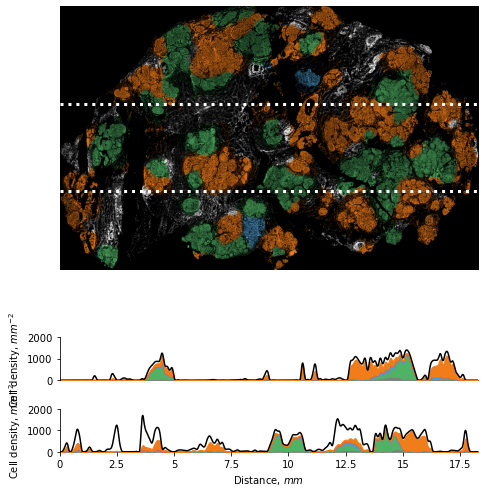

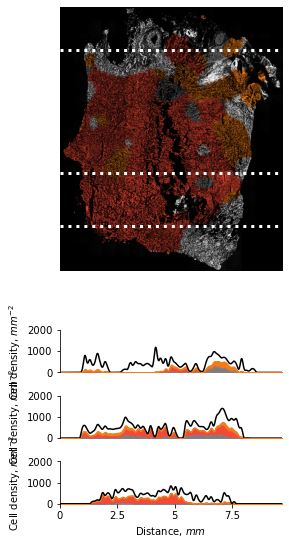

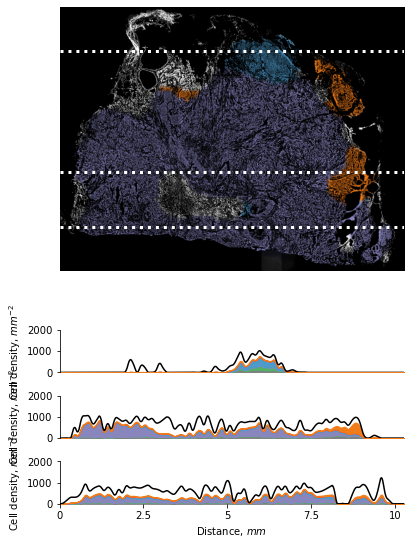

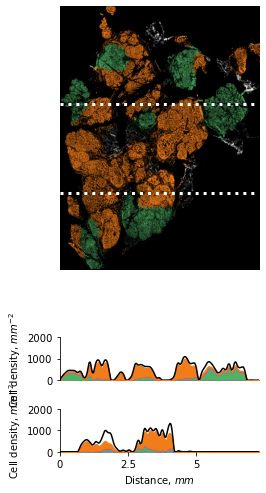

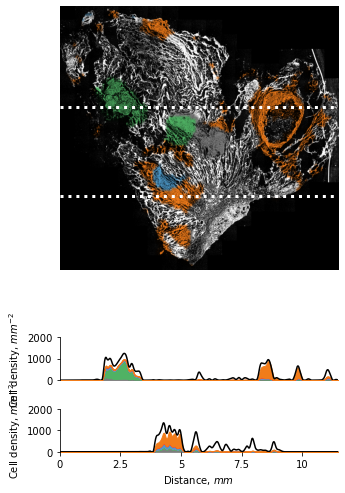

In [12]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42


def format_number(x, dec=1):
    x = float(x)
    if x % 1 == 0:
        return int(x)
    else:
        return round(x, dec)

ids2plot = [0,1,2,3,4]    

fixed_y_gridsize = [np.array([[int(x) for x in list(mut_sample_list[0]._scaffold_image.shape)[::-1]][1]] + [300]*len(stackplot_params[k])) for k in ids2plot]
fixed_y_size = [x.sum()/500 for x in fixed_y_gridsize]

pixel2um = 0.325
grid_mm2 = (Sample.get_img_size(mut_sample_list[0].image)[0] * pixel2um / sample_dims[0][0])**2 / 1e6

cmaps = {'grey':"Greys", 'green':"Greens", 'purple':"Purples",'magenta':"RdPu",'blue':"Blues",'red':"Reds",'orange':"YlOrBr",'wt':"Greys", 'residuals':"Greys"}

names = ['grey','green', 'purple', 'blue', 'red', 'orange'] + 1 * ['wt']
c = [get_cmap(cmaps[n])(150) for n in names]
#c[0] = get_cmap("cool")(10)
F = [samples_hierarchical_errosion[f'F_{s}'].mean(0).reshape(*sample_dims[s],-1) for s in range(n_samples)]
Lm = [samples_hierarchical_errosion[f'lm_n_{s}'].mean(0).reshape(*sample_dims[s]) for s in range(n_samples)]
Fmap = [(f[:,:,:n_factors-2]).argmax(2) for f in F]
Fn = [((f[:,:,n_factors-2:]).sum(2) > 0.75) | (cv2.blur(l,(3,3)) / grid_mm2 < 100 / pixel2um) for f, l in zip(F, Lm)]
n = [samples_hierarchical_errosion['lm_n_{}'.format(s)].mean(0).reshape(*sample_dims[s]).T[::-1, :] for s in range(n_samples)]
for ind, i in enumerate(ids2plot):
    img = mut_sample_list[i]._scaffold_image #tifffile.imread(mut_sample_list[i].image)
    s = img.shape
    s = tuple([int(x) for x in list(s)[::-1]])
    p35, p90 = np.percentile(img, (35, 90))
    processed_img = exposure.rescale_intensity(img, in_range=(p35, p90))
    b = cv.resize(processed_img, s)[::-1,:]/255.
    
    
    b = np.maximum(np.minimum(b,1),0)
    Fc = np.array([c[int(i)] for i in Fmap[i].flatten()]).reshape((*Fmap[i].shape,-1)).transpose((1,0,2))[::-1,:,:3]
    Fc[Fn[i].T[::-1,:],:]=1.0
    
    scale = s[0]/Fc.shape[1]
    scaffold_image_rescale = 15
    x_axis_rescale = (fixed_y_gridsize[ind][0]) / s[1] * s[0] / 500
 
    fig, axs = plt.subplots(fixed_y_gridsize[ind].size, 1, figsize=(x_axis_rescale, fixed_y_size[ind]*1.5), gridspec_kw={'height_ratios': fixed_y_gridsize[ind]}, sharex=True)
    #axs[0].plot([b.shape[1]*0.9 - 2.5e3 / pixel2um / scaffold_image_rescale, b.shape[1]*0.9], [b.shape[0]*0.95, b.shape[0]*0.95], color='white', lw=5)
    
    
    if i == 1:
        axs[0].imshow((cv.resize(Fc, s) * b.reshape(*b.shape,1))[::-1])#, alpha=n[0]/n[0].max())
        flipped = True
    else:
        axs[0].imshow(cv.resize(Fc, s) * b.reshape(*b.shape,1))
        flipped = False
    axs[0].axis('off')
    for sect in range(fixed_y_gridsize[ind].size - 1):
        axs[0].axhline((stackplot_params[i][sect]-1) * (s[1] / sample_dims[i][1]), linestyle='dotted', lw=3, color='white')
        plot_density_stacked(i, stackplot_params[i][sect], ax=axs[sect+1], flipped=flipped, rescale_y=scale)
        axs[sect+1].set_ylabel('Cell density, $mm^{-2}$')
    axs[-1].set_xticks(np.arange(0, s[0], 2.5 / (scaffold_image_rescale * 0.325 / 1e3)))
    xticklabels = np.arange(0, s[0] * scaffold_image_rescale * 0.325 / 1e3, 2.5)
    xticklabels = [format_number(x) for x in xticklabels]
    axs[-1].set_xticklabels(xticklabels)
    axs[-1].set_xlabel('Distance, $mm$')
    axs[-1].get_xaxis().set_visible(True)
    plt.xlim(0, s[0])
    #plt.savefig(f'./images/2085-{[7,2,5,6,8][i]}_stacked_densities_small.pdf'.format(i), dpi=300)
    plt.show()

## Validation

### construct data

100%|██████████| 56/56 [00:00<00:00, 58.58it/s]


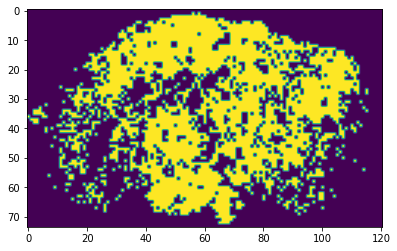

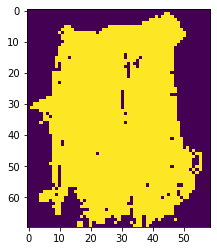

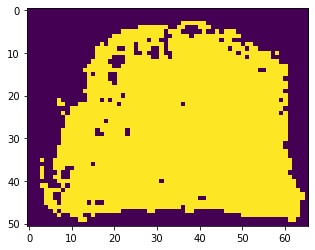

In [13]:
scale = 3 / np.sqrt(2)

val_mask = mask_infisble(val_sample_list, scale, probability=0.6, plot=True)
data4model = generate_data4model(samples_list=val_sample_list, genes=tree.columns, M=M, n_aug=1)

n_samples = data4model['n_samples']
n_genes = data4model['n_genes']
iss_data = data4model['iss_data']
tiles_axes = data4model['tiles_axes']
cells_counts = data4model['cells_counts']
sample_dims = data4model['sample_dims']
n_factors = data4model['n_factors']
n_aug = data4model['n_aug']

In [ ]:
with pm.Model() as model_hierarchical_errosion:
    
    xi = [pm.Gamma('xi_{}'.format(s), mu=0.5, sigma=1, shape=n_genes) for s in range(n_samples)]
    r_mu = pm.Gamma('r', mu=0.5, sigma=1, shape=n_genes)
    #r = [pm.Gamma('r_{}'.format(s), mu=r_mu, sigma=r_mu/20, shape=n_genes) for s in range(n_samples)]
    r_de = [pm.Lognormal('r_de_{}'.format(s), mu=0, sigma=0.05, shape=n_genes) for s in range(n_samples)]
    r = [r_mu * r_de_i for r_de_i in r_de]
    
    cov_func1_f = [[pm.gp.cov.ExpQuad(1, ls=2.5*np.sqrt(scale)) for i in range(n_factors-1 + n_aug)] for s in range(n_samples)]
    cov_func2_f = [[pm.gp.cov.ExpQuad(1, ls=2.5*np.sqrt(scale))  for i in range(n_factors-1 + n_aug)] for s in range(n_samples)]

    gp_f = [[pm.gp.LatentKron(cov_funcs=[cov_func1_f[s][i], cov_func2_f[s][i]]) for i in range(n_factors - 1 + n_aug)] for s in range(n_samples)] 
    f_f = [[gp_f[s][i].prior(name, Xs=tiles_axes[s]) for i, name in enumerate(['f_f_{}_{}'.format(i, s) for i in range(n_factors - 1 + n_aug)])] for s in range(n_samples)]
    #f_f = [[pm.Normal(name, mu=0, sigma=1, shape=len(cells_counts[s]))  for i, name in enumerate(['f_f_{}_{}'.format(i, s) for i in range(n_factors - 1 + n_aug)])] for s in range(n_samples)]
    f_f = [f_f[s] + [np.ones(len(cells_counts[s]))*(-1.7)] for s in range(n_samples)]
    F_matrix = [tt.stack(f_f[s], axis=1) for s in range(n_samples)]

    F = [pm.Deterministic('F_{}'.format(s), tt.exp(F_matrix[s] / 2) / tt.exp(F_matrix[s] / 2).sum(axis=1)[:,None]) for s in range(n_samples)]

    lm_n = [pm.Gamma('lm_n_{}'.format(s), mu=50, sigma=100, shape=len(cells_counts[s])) for s in range(n_samples)]
    pois_n = [pm.Poisson('n_{}'.format(s), lm_n[s], observed=cells_counts[s]) for s in range(n_samples)]  

    E0 = 4 # ie 1 for most loci; 4 for amps
    E = [E0 * pm.Beta(f'E_{s}',0.01,1, shape=(n_aug, n_genes)) for s in range(n_samples)] #(M - M[-1,:]).max(0) 

    M_de = pm.Lognormal('M_de', mu=0.0, sigma=0.05, shape=M.shape)    
    M_de = tt.pow(M_de, tt.concatenate([tt.ones((n_factors-n_wt,1)), 2 * tt.ones((n_wt,1))],axis=0))
    M_aug = M * M_de
    M_aug_de = [pm.Lognormal(f'M_aug_{s}', mu=0.0, sigma=0.05, shape=(n_factors, n_genes)) for s in range(n_samples)]

    
    theta_pure = [pm.Deterministic('theta_{}'.format(s), tt.dot(F[s], tt.concatenate([M,E[s]]))) for s in range(n_samples)]
    
    theta = [pm.Deterministic('theta_mod_{}'.format(s), tt.dot(F[s], tt.concatenate([M_aug * M_aug_de[s] , E[s]], axis=0))) for s in range(n_samples)] #* M_aug_de[s]

   
    z = 1 - pm.Beta('z', 1, 25, shape=n_genes)/4 ## ie ~1% probe confusion
    
    confusion_matrix = tt.eye(n_genes)

    for i in range(n_genes):
        for j in range(n_genes):
            if tree.columns[i].endswith('mut') and tree.columns[j].endswith('mut') and tree.columns[i][:-3] == tree.columns[j][:-3]:
                confusion_matrix = tt.set_subtensor(confusion_matrix[i, j], z[i])
    
            if tree.columns[i].endswith('wt') and tree.columns[j].endswith('wt') and tree.columns[i][:-2] == tree.columns[j][:-2]:
                confusion_matrix = tt.set_subtensor(confusion_matrix[i, j], z[i])#
    
            if tree.columns[i][:-3] == tree.columns[j][:-2]:
                confusion_matrix = tt.set_subtensor(confusion_matrix[i, j], 1-z[i])#
    
            if tree.columns[i][:-2] == tree.columns[j][:-3]:
                confusion_matrix = tt.set_subtensor(confusion_matrix[i, j], 1-z[i])

    
    lm = [theta[s]  * lm_n[s][:, None] * r[s][None,:] for s in range(n_samples)]
    

    T = [tt.dot(F[s].sum(axis=0), tt.concatenate([M, E[s]], axis=0)) for s in range(n_samples)] ## Just sum actual genotypes
    T_freq = [T[s][[np.where(tree.columns == gene + 'mut')[0][0] for gene in wgs_names]] \
              / (T[s][[np.where(tree.columns == gene + 'wt')[0][0] for gene in wgs_names]] \
                 + T[s][[np.where(tree.columns == gene + 'mut')[0][0] for gene in wgs_names]]) for s in range(n_samples)]
    
    beta_prior = [Beta_sum('beta_prior_{}'.format(s), n=(val_mask[s].sum()), alpha=(wgs_mut[s]/5 + 1), beta=(wgs_wt[s]/5 + 1), observed=T_freq[s][:]) for s in range(n_samples)]
    


    lm_er = [pm.Deterministic('lm_er_{}'.format(s), tt.dot(lm[s], confusion_matrix) + xi[s][None,:]) for s in range(n_samples)]
    
    o = pm.Gamma('o', mu=100, sd=10, shape=n_genes)

    signal = [pm.NegativeBinomial('exp_{}'.format(s), mu = lm_er[s][val_mask[s],:], alpha=o, observed=iss_data[s][val_mask[s],:]) for s in range(n_samples)]


In [ ]:
np.random.seed(1234)
pm.set_tt_rng(1234)

with model_hierarchical_errosion :
    advi = pm.ADVI()
    approx_val_hierarchical_errosion = advi.fit(n=15000, obj_optimizer=pm.adam(learning_rate=0.01))
    #approx_hierarchical_errosion = advi.fit(n=2000, obj_optimizer=pm.adam(learning_rate=0.01))
    


In [14]:
#load/save model

#with open('./data/approx_2805_val_final_16-02.pkl', 'wb') as file:
#    pkl.dump(approx_val_hierarchical_errosion, file)

with open('../pymc_model/data/approx_2805_val_final_16-02.pkl', 'rb') as file:
    approx_val_hierarchical_errosion = pkl.load(file)

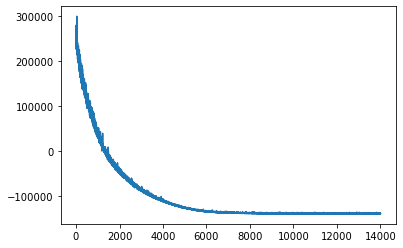

In [15]:
plt.plot(approx_val_hierarchical_errosion.hist[1000:])
samples_val_hierarchical_errosion = approx_val_hierarchical_errosion.sample(300)


### Plot fieds

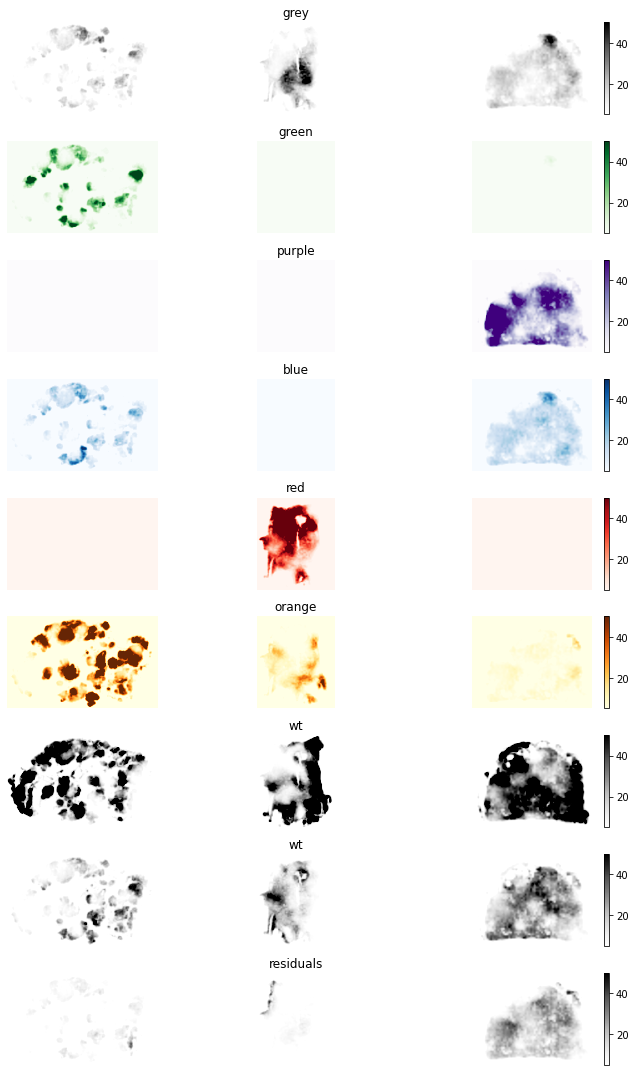

In [16]:
from matplotlib.colors import ListedColormap

alphas = np.concatenate((np.abs(np.linspace(0, 0, 256 - 200)), np.abs(np.linspace(0, 1.0, 256 - 56))))
N = 256

vals = np.ones((N, 4))
vals[:, 0] = np.linspace(1, 240/256, N)
vals[:, 1] = np.linspace(1, 228/256, N)
vals[:, 2] = np.linspace(1, 66/256, N)
vals[:, 3] = alphas
YellowCM = ListedColormap(vals)

plt.figure(figsize=(20/2, 30/2))
c = 0
#names = ['grey','green', 'purple', 'magenta', 'blue', 'red', 'orange'] + n_wt * ['wt'] + n_aug *['residuals']
names = ['grey','green', 'purple', 'blue', 'red', 'orange'] + n_wt * ['wt'] + n_aug *['residuals']

#names = names[1:]

cmaps = {'grey':"Greys", 'green':"Greens", 'purple':"Purples",'magenta':"RdPu",'blue':"Blues",'red':"Reds",'orange':"YlOrBr",'wt':"Greys", 'residuals':"Greys"}
for i, ide in enumerate(np.arange(n_factors+n_aug)):
    for s in range(n_samples):
        plt.subplot(n_factors+n_aug,n_samples,c+1)
        #plt.imshow(resized_img_list[s])
        plt.imshow(cv2.resize((np.percentile(samples_val_hierarchical_errosion['F_{}'.format(s)][:,:,ide] * samples_val_hierarchical_errosion['lm_n_{}'.format(s)][:,:], 50, axis=0) ).reshape(*sample_dims[s]).T[::-1, :], tuple(np.array(sample_dims[s])*4)),
                   cmap=plt.get_cmap(cmaps[names[ide]]), vmin=5, vmax=50)
        plt.gca().axis('off')
        if s == 1:
            plt.title(names[ide])
        c += 1
    plt.colorbar()
        
plt.rcParams['figure.facecolor'] = 'w'
plt.tight_layout()
plt.show()

## Compare main and validation sets

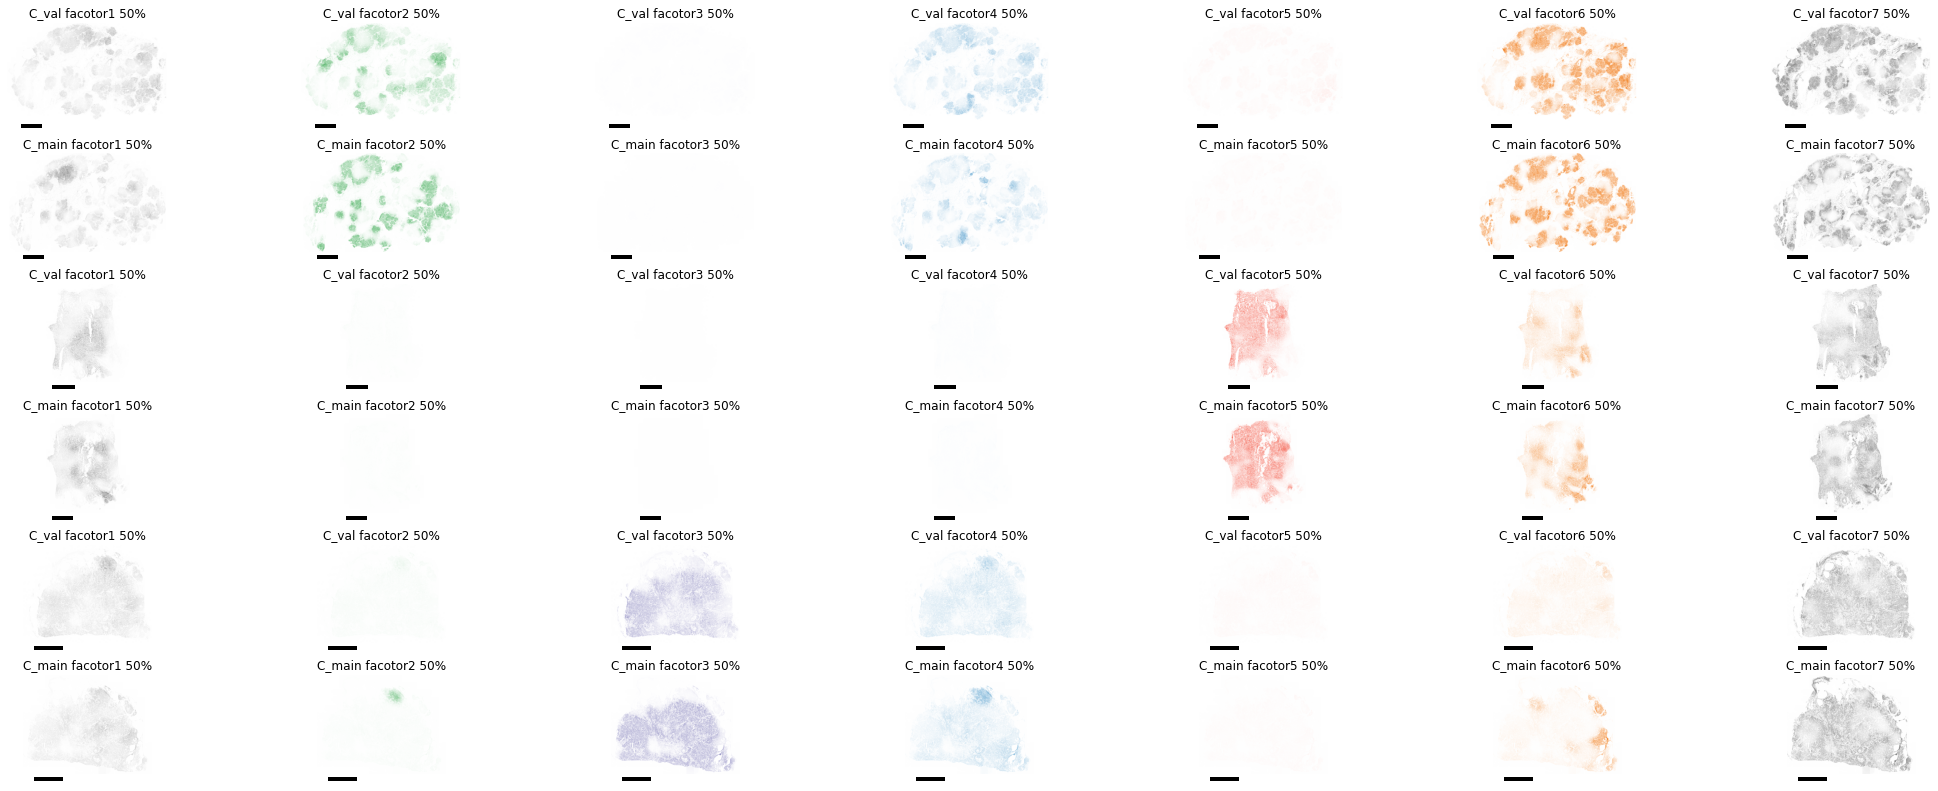

In [17]:

plt.rcParams['figure.facecolor'] = 'w'

c = [get_cmap(cmaps[n])(150) for n in names]

data4model = generate_data4model(samples_list=val_sample_list, genes=tree.columns, M=M, n_aug=1)
sample_dimsR0 = data4model['sample_dims']

data4model = generate_data4model(samples_list=mut_sample_list, genes=tree.columns, M=M, n_aug=1)
sample_dimsR1 = data4model['sample_dims']

FR0 = [samples_val_hierarchical_errosion[f'F_{s}'].reshape(300, *sample_dimsR0[s],-1).copy() for s in range(3)]
FR1 = [samples_hierarchical_errosion[f'F_{s}'].reshape(300, *sample_dimsR1[s],-1).copy() for s in range(3)]
for i in range(3):
    FR0[i][:,:,:,7] += FR0[i][:,:,:,8]
    FR1[i][:,:,:,7] += FR1[i][:,:,:,8]
plt.figure(figsize=(6*6, 14))
counter = 0 
for i in range(3):
    imgR0 = val_sample_list[i]._scaffold_image
    imgR1 = mut_sample_list[i]._scaffold_image #tifffile.imread(mut_sample_list[i].image)
    sR0 = imgR0.shape
    sR0 = tuple([int(x/2) for x in list(sR0)[::-1]])
    sR1 = imgR1.shape
    sR1 = tuple([int(x/2) for x in list(sR1)[::-1]])
    
    p35, p90 = np.percentile(imgR0, (35, 90))
    processed_img = exposure.rescale_intensity(imgR0, in_range=(p35, p90))
    b0 = cv.resize(processed_img, sR0)[::-1,:]/255.
    
    p35, p90 = np.percentile(imgR1, (35, 90))
    processed_img = exposure.rescale_intensity(imgR1, in_range=(p35, p90))
    b1 = cv.resize(processed_img, sR1)[::-1,:]/255.
    
    
    for factor in range(7):
        for percentile in [50]:
            if factor == 7:
                vmax = 0.7
            else:
                vmax = 0.20
            plt.subplot(6,7,counter+1)
            b0 = np.maximum(np.minimum(b0,1),0)
            Fc = np.minimum(np.percentile(FR0[i][:,:,:,factor], percentile, axis=0), vmax) / vmax
            Fc = (Fc.T[::-1,:][:,:,None] * (1-np.array(c[factor])))[:,:,:3]
            #plt.imshow(cv.resize(Fc, sR0))
            plt.imshow(1-cv.resize(Fc, sR0) * b0.reshape(*b0.shape,1))
            plt.title(f"{['D_val', 'A_val', 'C_val'][s]} facotor{factor+1} {percentile}%")
            plt.plot([b0.shape[1]*0.1, b0.shape[1]*0.1 + 1e3 / 0.325 / 15 ], [b0.shape[0] * 1.05, b0.shape[0] * 1.05], color='black', lw=4)
            plt.gca().axis('off')
            counter += 1
            
    for factor in range(7):
        for percentile in [50]:
            if factor == 7:
                vmax = 0.7
            else:
                vmax = 0.20
            plt.subplot(6,7,counter+1)
            b1 = np.maximum(np.minimum(b1,1),0)
            Fc = np.minimum(np.percentile(FR1[i][:,:,:,factor], percentile, axis=0), vmax) / vmax
            Fc = (Fc.T[::-1,:][:,:,None] * (1-np.array(c[factor])))[:,:,:3]
            plt.imshow(1-cv.resize(Fc, sR1) * b1.reshape(*b1.shape,1))
            plt.title(f"{['D_main', 'A_main', 'C_main'][s]} facotor{factor+1} {percentile}%")
            plt.plot([b1.shape[1]*0.1, b1.shape[1]*0.1 + 1e3 / 0.325 / 15 ], [b1.shape[0] * 1.05, b1.shape[0] * 1.05], color='black', lw=4)
            plt.gca().axis('off')
            counter += 1

    
    #plt.savefig(f'./images/SuppFig3A-{["d","a","c"][i]}.pdf'.format(i))

# Expression analysis

Knowing spatial cell density distribution of clones we attempt to characterise the clones phenotypically. There are two characteristics we use -- nuclei morphology and <it>in situ</it> sequencing expression signals. In both cases we characterise the whole region of high clone abundance. It is important to note that we do not distinguish cancer clone cells from any other type of cells and characterise selected location as a whole. The minimal unit of region is the grid tile. 

#### compare purple mutations DCIS purple vs Invasive purple subclones

In [18]:
purple_muts = ['PTEN1mut', 'TMEM8Amut', 'DSELmut', 'KIF14mut', 'FZD4mut', 'AMZ1mut', 'EMILIN2mut', 'ZNF468mut']

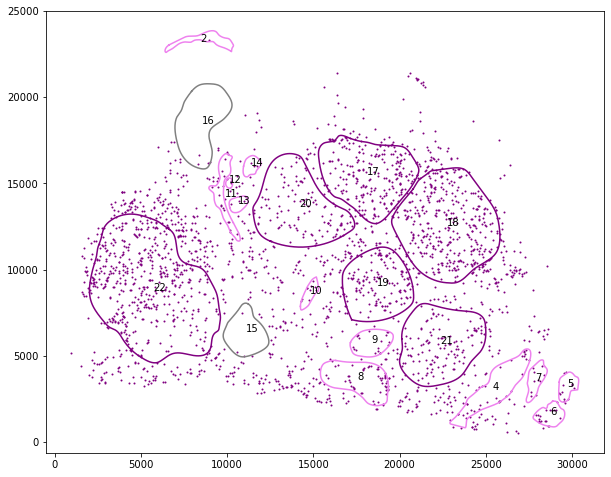

In [19]:
plt.figure(figsize=(10,10))
s = 2
df_mut = pd.DataFrame(mut_sample_list[s].data)
colors = {'cls-1':'violet', 'cls-2':'grey', 'cls-3':'purple'}
paths = mut_sample_list[s].ducts['paths']
duct_type = mut_sample_list[s].ducts['linetype']
plt.scatter(df_mut.PosX[df_mut.Gene == purple_muts[0]], df_mut.PosY[df_mut.Gene == purple_muts[0]], color='purple', s=1, alpha=1)
for i in range(len(paths)):
    if not i in [1,3,0,23,24]:
        plt.text(paths[i][:,0].mean(), paths[i][:,1].mean(),i)
        plt.plot(paths[i][:,0], paths[i][:,1], color=colors[duct_type[i]])
plt.gca().set_aspect('equal', adjustable='box')


In [20]:
condition_c_inv = (np.array(mut_sample_list[2].ducts['linetype']) == 'cls-3')
condition_c_dcis = (np.isin(np.arange(len(np.array(mut_sample_list[2].ducts['linetype']))), [4,5,6,7,8,9,10,11,12,13]))
condition_c_dcis_blue = (np.isin(np.arange(len(np.array(mut_sample_list[2].ducts['linetype']))), [0,23,24]))

mut_dcis_c = mut_sample_list[2].filter_by_ducts(condition_c_dcis)
mut_inv_c = mut_sample_list[2].filter_by_ducts(condition_c_inv)
mut_dcis_blue_c = mut_sample_list[2].filter_by_ducts(condition_c_dcis_blue)


In [21]:
mut_dcis_c_df = pd.DataFrame(mut_dcis_c.data)
mut_inv_c_df = pd.DataFrame(mut_inv_c.data)
mut_dcis_blue_c_df = pd.DataFrame(mut_dcis_blue_c.data)

<b>Fig. S4. Temporal ordering during progression to invasion (A)</b> Barplots of purple subclone
mutation signals in late DCIS and invasive cancer regions in PD9694c revealing similarity between
the purple clone occupying both DCIS and invasive compartments (CI=5-95%).

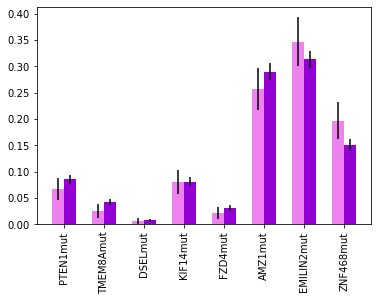

In [22]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.bar(np.arange(len(purple_muts))-0.15, mut_dcis_c_df[mut_dcis_c_df.Gene.isin(purple_muts)].groupby('Gene').count()['PosX']/
        np.sum(mut_dcis_c_df[mut_dcis_c_df.Gene.isin(purple_muts)].groupby('Gene').count()['PosX']), color='violet', width=0.3,
        yerr=(mut_dcis_c_df[mut_dcis_c_df.Gene.isin(purple_muts)].groupby('Gene').count()['PosX'])**0.5*2/
        np.sum(mut_dcis_c_df[mut_dcis_c_df.Gene.isin(purple_muts)].groupby('Gene').count()['PosX']))
plt.bar(np.arange(len(purple_muts))+0.15, mut_inv_c_df[mut_inv_c_df.Gene.isin(purple_muts)].groupby('Gene').count()['PosX']/
       np.sum(mut_inv_c_df[mut_inv_c_df.Gene.isin(purple_muts)].groupby('Gene').count()['PosX']), color='darkviolet', width=0.3,
       yerr=(mut_inv_c_df[mut_inv_c_df.Gene.isin(purple_muts)].groupby('Gene').count()['PosX'])**0.5*2/
        np.sum(mut_inv_c_df[mut_inv_c_df.Gene.isin(purple_muts)].groupby('Gene').count()['PosX']))
plt.xticks(np.arange(len(purple_muts)), purple_muts, rotation=90)
#plt.savefig(f'./images/DCISvsINV_purple_mut_comparison.pdf')

plt.show()

## DCIS and Invasive subclones in samples PD9694a and PD9694c
For samples with a mixture of DCIS and invasive morphologies -- PD9694a, PD9694c -- we have selected regions with the highest abundance of the respective clone within a border of a respective morphology (invasive or DCIS) as this was pertinent to the biological question.

### Data preparation 

In [23]:
new_labels = ['a2', 'c2']
old_labels = ['2', '5']
version= ['', '']

old_folders = ['Expression', 'Expression']
masks_svgs = ['../contours/Exp2805_2_full_autobright_mini_ducts-01.svg',
              '../contours/Exp2805_5_full_autobright_mini_ducts-01.svg']
old_prefix = ['', '']

exp_sample_list_unwarped = []
for i in range(len(new_labels)):
    exp_sample_list_unwarped.append(Sample(iss_data=f'/nfs/research1/gerstung/mg617/ISS_data/Exp_PD9694{new_labels[i]}/decoding/Exp_PD9694{new_labels[i]}_GMMdecoding.csv',
               image=f'/nfs/research1/gerstung/artem/projects/spatial_bayes/GMM_restored_DAPI/Exp_PD9694{new_labels[i]}.tif',
               cell_data=f'../ultra_hd_segmentation/Patient_2085/{old_folders[i]}/{old_prefix[i]}2805_{old_labels[i]}_segmented/{old_prefix[i]}2805_{old_labels[i]}_cellpos.csv',
               masks_svg=masks_svgs[i]))


for i, sample in enumerate(exp_sample_list_unwarped):
    
    single_flag = True
    if ''.join(os.listdir(f'../Globus/DAPI_2805/{old_folders[i]}/{old_prefix[i]}2805_{old_labels[i]}/')).find('full') != -1:
        single_flag = False

    for file in os.listdir(f'../Globus/DAPI_2805/{old_folders[i]}/{old_prefix[i]}2805_{old_labels[i]}/'):
        if single_flag:
            if file.find('autobright.tif') != -1 or file.find('autbright.tif') != -1:
                break
        else:
            if file.find('full_autobright.tif') != -1:
                break
                
    
    #sample.transform_points2background(f'../Globus/DAPI_2805/{old_folders[i]}/{old_prefix[i]}2805_{old_labels[i]}/{file}', upsampling=15)

In [24]:
new_labels = ['a2', 'c2']
old_labels = ['2', '5']
version= ['', '']

old_folders = ['Immuno', 'Immuno']
masks_svgs = ['../contours/Imm2805_2_full_autobright_mini_ducts-01.svg',
              '../contours/Imm2805_5_full_autobright_mini_ducts-01.svg']
old_prefix = ['', '']

imm_sample_list_unwarped = []
for i in range(len(new_labels)):
    imm_sample_list_unwarped.append(Sample(iss_data=f'/nfs/research1/gerstung/mg617/ISS_data/Imm_PD9694{new_labels[i]}/decoding/Imm_PD9694{new_labels[i]}_GMMdecoding.csv',
               image=f'/nfs/research1/gerstung/artem/projects/spatial_bayes/GMM_restored_DAPI/Imm_PD9694{new_labels[i]}.tif',
               cell_data=f'../ultra_hd_segmentation/Patient_2085/{old_folders[i]}/{old_prefix[i]}2805_{old_labels[i]}_segmented/{old_prefix[i]}2805_{old_labels[i]}_cellpos.csv',
               masks_svg=masks_svgs[i]))


for i, sample in enumerate(imm_sample_list_unwarped):
    
    single_flag = True
    if ''.join(os.listdir(f'../Globus/DAPI_2805/{old_folders[i]}/{old_prefix[i]}2805_{old_labels[i]}/')).find('full') != -1:
        single_flag = False

    for file in os.listdir(f'../Globus/DAPI_2805/{old_folders[i]}/{old_prefix[i]}2805_{old_labels[i]}/'):
        if single_flag:
            if file.find('autobright.tif') != -1 or file.find('autbright.tif') != -1:
                break
        else:
            if file.find('full_autobright.tif') != -1:
                break
                
    
    #sample.transform_points2background(f'../Globus/DAPI_2805/{old_folders[i]}/{old_prefix[i]}2805_{old_labels[i]}/{file}', upsampling=15)

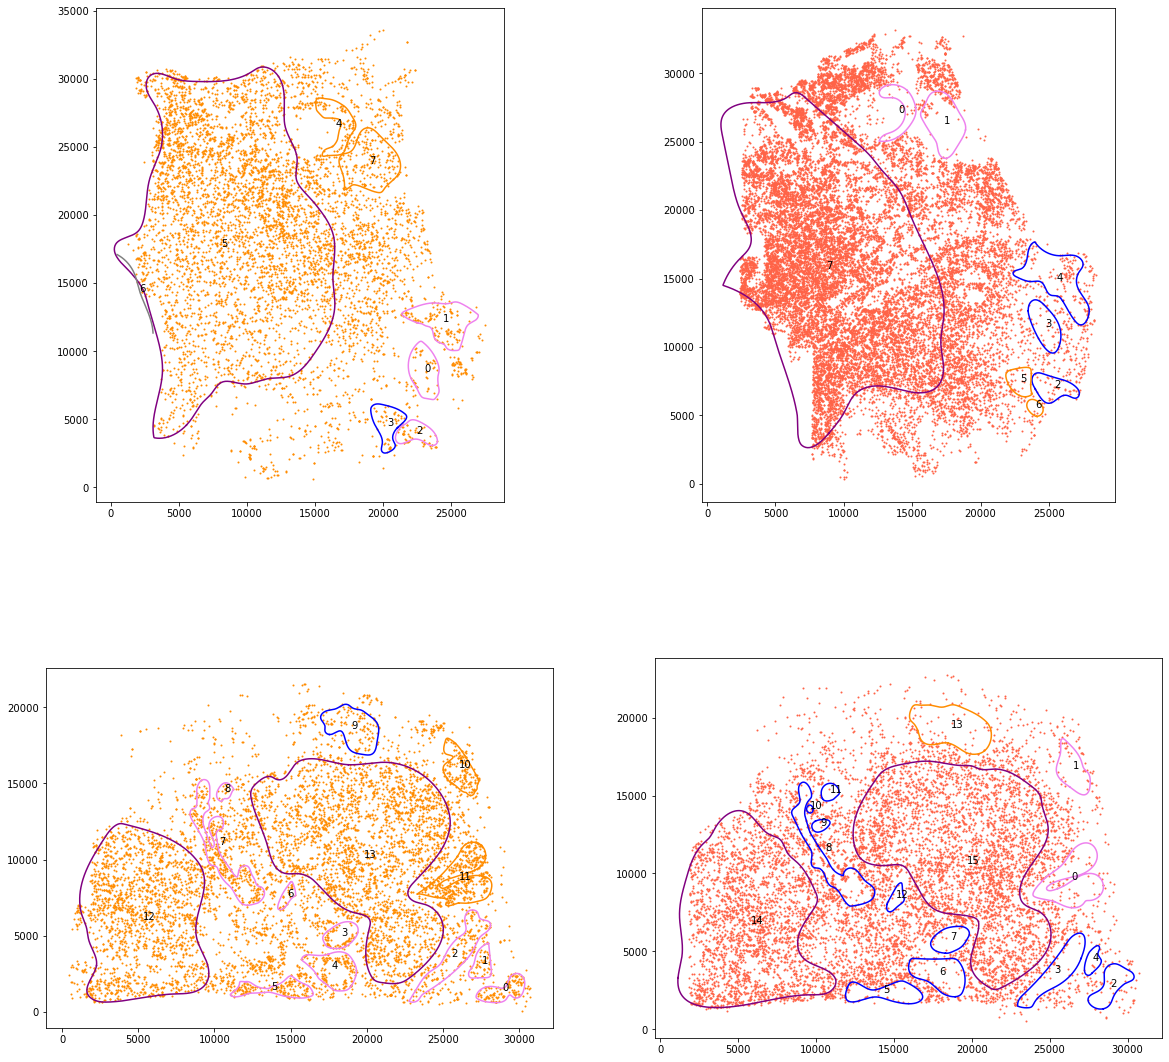

In [25]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
s = 0
df_exp = pd.DataFrame(exp_sample_list_unwarped[s].data)
df_imm = pd.DataFrame(imm_sample_list_unwarped[s].data)
colors = {'st0':'violet', 'st1':'blue', 'st2':'darkorange', 'st3':'purple', 'st4': 'grey'}
paths = exp_sample_list_unwarped[s].ducts['paths']
duct_type = exp_sample_list_unwarped[s].ducts['linetype']
plt.scatter(df_exp.PosX[df_exp.Gene == 'CCND1'], df_exp.PosY[df_exp.Gene == 'CCND1'], color='darkorange', s=1, alpha=1)
for i in range(len(paths)):
    plt.text(paths[i][:,0].mean(), paths[i][:,1].mean(),i)
    plt.plot(paths[i][:,0], paths[i][:,1], color=colors[duct_type[i]])
plt.gca().set_aspect('equal', adjustable='box')
plt.subplot(2,2,2)
paths = imm_sample_list_unwarped[s].ducts['paths']
duct_type = imm_sample_list_unwarped[s].ducts['linetype']
plt.scatter(df_imm.PosX[df_imm.Gene == 'FAP'], df_imm.PosY[df_imm.Gene == 'FAP'], color='tomato', s=1, alpha=1)
for i in range(len(paths)):
    plt.text(paths[i][:,0].mean(), paths[i][:,1].mean(),i)
    plt.plot(paths[i][:,0], paths[i][:,1], color=colors[duct_type[i]])
plt.gca().set_aspect('equal', adjustable='box')
plt.subplot(2,2,3)
s = 1
df_exp = pd.DataFrame(exp_sample_list_unwarped[s].data)
df_imm = pd.DataFrame(imm_sample_list_unwarped[s].data)
colors = {'st0':'violet', 'st1':'blue', 'st2':'darkorange', 'st3':'purple', 'st4': 'grey'}
paths = exp_sample_list_unwarped[s].ducts['paths']
duct_type = exp_sample_list_unwarped[s].ducts['linetype']
plt.scatter(df_exp.PosX[df_exp.Gene == 'CCND1'], df_exp.PosY[df_exp.Gene == 'CCND1'], color='darkorange', s=1, alpha=1)
for i in range(len(paths)):
    plt.text(paths[i][:,0].mean(), paths[i][:,1].mean(),i)
    plt.plot(paths[i][:,0], paths[i][:,1], color=colors[duct_type[i]])
plt.gca().set_aspect('equal', adjustable='box')
plt.subplot(2,2,4)
paths = imm_sample_list_unwarped[s].ducts['paths']
duct_type = imm_sample_list_unwarped[s].ducts['linetype']
plt.scatter(df_imm.PosX[df_imm.Gene == 'FAP'], df_imm.PosY[df_imm.Gene == 'FAP'], color='tomato', s=1, alpha=1)
for i in range(len(paths)):
    plt.text(paths[i][:,0].mean(), paths[i][:,1].mean(),i)
    plt.plot(paths[i][:,0], paths[i][:,1], color=colors[duct_type[i]])
plt.gca().set_aspect('equal', adjustable='box')


In [26]:
ducts_mapping = {'exp_a': {'inv': [5], 'dcis_inv':[4,7], 'dcis_pure':[1,2]},
                 'imm_a': {'inv': [7], 'dcis_inv':[0,1], 'dcis_pure':[2,4]},
                 'exp_c': {'inv': [12,13], 'dcis_inv':[0,1,2,3,4,5,6,7,8], 'dcis_pure':[9]},
                 'imm_c': {'inv': [14,15], 'dcis_inv':[2,3,4,5,6,7,8,9,10,11,12], 'dcis_pure':[13]}}



In [27]:
exp_dcis_a = exp_sample_list_unwarped[0].filter_by_ducts()
#exp_dcis_a2 = exp_sample_list[1].filter_by_ducts(condition_a_inv | condition_a_dcis_yellow)
exp_dcis_c = exp_sample_list_unwarped[1].filter_by_ducts()
#exp_dcis_c2 = exp_sample_list[2].filter_by_ducts(condition_c_inv | condition_c_dcis_blue)

imm_dcis_a = imm_sample_list_unwarped[0].filter_by_ducts()
#imm_dcis_a2 = imm_sample_list[1].filter_by_ducts(condition_a_inv | condition_a_dcis_yellow)

imm_dcis_c = imm_sample_list_unwarped[1].filter_by_ducts()
#imm_dcis_c2 = imm_sample_list[2].filter_by_ducts(condition_c_inv | condition_c_dcis_blue)

exp_dcis_inv_list = [exp_dcis_a, exp_dcis_c]
imm_dcis_inv_list = [imm_dcis_a, imm_dcis_c]

100%|██████████| 66/66 [00:00<00:00, 223.20it/s]


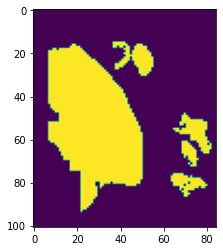

100%|██████████| 66/66 [00:00<00:00, 233.76it/s]


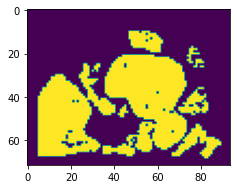

100%|██████████| 66/66 [00:00<00:00, 216.50it/s]
/nfs/research1/gerstung/artem/projects/spatial_bayes/BaSISS/basiss/pile_of_code.py:584: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  paths_matplot = [mpltPath.Path(paths_interpol[subset][i]) for i in range(len(paths_interpol[subset]))]
100%|██████████| 66/66 [00:00<00:00, 5242.28it/s]


In [28]:
samples_id = [0,1]
n_samples = len(samples_id)

mask_exp = []
mask_imm = []

scale = 3
for i in range(n_samples):
    exp_dcis_inv_list[i].data_to_grid(scale_factor=scale, probability=0.6)
    imm_dcis_inv_list[i].data_to_grid(scale_factor=scale, probability=0.6)
    t_exp = np.array([s for s in exp_dcis_inv_list[i].gene_grid.values()]).sum(0)
    t_imm = np.array([s for s in imm_dcis_inv_list[i].gene_grid.values()]).sum(0)
    
    mask_infisiable_exp = exp_dcis_inv_list[i].gene_grid['infeasible']/t_exp < 0.1
    mask_infisiable_imm = imm_dcis_inv_list[i].gene_grid['infeasible']/t_imm < 0.1

    plt.figure(figsize=(8,4))
    #plt.subplot(1,2,1)
    plt.imshow(mask_infisiable_exp.T[::-1,:])
    plt.subplot(1,2,2)
    plt.imshow(mask_infisiable_imm.T[::-1,:])
    plt.show()
    #mask.append(mask_infisiable.flatten())
    mask_exp.append(mask_infisiable_exp.flatten())
    mask_imm.append(mask_infisiable_imm.flatten())

# renaming inconsitent genes 
for i in range(n_samples):
    exp_dcis_inv_list[i].data_to_grid(scale_factor=scale, probability=0.6)
    imm_dcis_inv_list[i].data_to_grid(scale_factor=scale, probability=0.6)
    if 'Oct-04' in exp_dcis_inv_list[i].gene_grid.keys():
        exp_dcis_inv_list[i].gene_grid['OCT-4'] = exp_sample_list[i].gene_grid.pop('Oct-04')
        exp_dcis_inv_list[i].genes[np.where(exp_sample_list[i].genes == 'Oct-04')] = 'OCT-4'

    
imm_genes = np.concatenate([imm_dcis_inv_list[0].genes[:-4], np.array(['perforin'])])
exp_genes = exp_dcis_inv_list[0].genes[:-3]


n_imm_genes = len(imm_genes)
n_exp_genes = len(exp_genes)

#create pseudosubclones which represent cancer cells in DCIS and INV regions 

# INV and 2 DCIS types
subclone_means_exp = [np.zeros((exp_dcis_inv_list[s].cell_grid.size, 3)) for s in range(n_samples)]
subclone_means_imm = [np.zeros((imm_dcis_inv_list[s].cell_grid.size, 3)) for s in range(n_samples)]


for s in range(n_samples):
    #inv
    tmp = exp_dcis_inv_list[s].filter_by_ducts([ducts_mapping[['exp_a', 'exp_c'][s]]['inv']])
    tmp.data_to_grid(scale_factor=scale, probability=0.6)
    subclone_means_exp[s][tmp.cell_grid.flatten()>0,0] = 1
                                                
    tmp = imm_dcis_inv_list[s].filter_by_ducts([ducts_mapping[['imm_a', 'imm_c'][s]]['inv']])
    tmp.data_to_grid(scale_factor=scale, probability=0.6)
    subclone_means_imm[s][tmp.cell_grid.flatten()>0,0] = 1
    #subclone_proportions_dcis_inv_wt[s][:,tmp.cell_grid.flatten()>0,2] = 2*np.log(np.exp(subclone_proportions[s][:,tmp.cell_grid.flatten()>0,6:]/2).sum(axis=2))
    #dcis
    tmp = exp_dcis_inv_list[s].filter_by_ducts([ducts_mapping[['exp_a', 'exp_c'][s]]['dcis_inv']])
    tmp.data_to_grid(scale_factor=scale, probability=0.6)
    subclone_means_exp[s][tmp.cell_grid.flatten()>0,1] = 1
                                                
    tmp = imm_dcis_inv_list[s].filter_by_ducts([ducts_mapping[['imm_a', 'imm_c'][s]]['dcis_inv']])
    tmp.data_to_grid(scale_factor=scale, probability=0.6)
    subclone_means_imm[s][tmp.cell_grid.flatten()>0,1] = 1
    
    tmp = exp_dcis_inv_list[s].filter_by_ducts([ducts_mapping[['exp_a', 'exp_c'][s]]['dcis_pure']])
    tmp.data_to_grid(scale_factor=scale, probability=0.6)
    subclone_means_exp[s][tmp.cell_grid.flatten()>0,2] = 1
                                                
    tmp = imm_dcis_inv_list[s].filter_by_ducts([ducts_mapping[['imm_a', 'imm_c'][s]]['dcis_pure']])
    tmp.data_to_grid(scale_factor=scale, probability=0.6)
    subclone_means_imm[s][tmp.cell_grid.flatten()>0,2] = 1


exp_iss_data = [np.transpose(np.array([exp_dcis_inv_list[i].gene_grid[k] for k in exp_genes]), [1,2,0]).reshape(-1, n_exp_genes) for i in range(n_samples)]
imm_iss_data = [np.transpose(np.array([imm_dcis_inv_list[i].gene_grid[k] for k in imm_genes]), [1,2,0]).reshape(-1, n_imm_genes) for i in range(n_samples)]

tiles_axes = [exp_dcis_inv_list[i].tile_axis for i in range(n_samples)]

exp_cells_counts = [exp_dcis_inv_list[i].cell_grid.flatten() for i in range(n_samples)]
imm_cells_counts = [imm_dcis_inv_list[i].cell_grid.flatten() for i in range(n_samples)]
exp_masks = [mask_exp[i] for i in range(n_samples)]
imm_masks = [mask_imm[i] for i in range(n_samples)]

sample_dims = [(int(tiles_axes[i][0][-1]+1), int(tiles_axes[i][1][-1]+1)) for i in range(n_samples)]
factors_id = [0,1,2]
n_factors = len(factors_id)

n_aug= 0

sample_separate_flag = True


### Define and run model

The essential idea behind the expression model is similar to the one we used in spatial mapping. ISS records a series of fluorescent spot, which are decoded into a set of barcodes corresponding to each of the targeted gene. Here we also represent counts of probes by a three dimensional array $\mathbf{D} \in \mathbb{N}^{|g|\times|x|\times|y|}$, where $g$ refers to the gene and $x$ and $y$ are coordinates on the grid.

The expected number of ISS signals is decomposed into maps of $s$ clone specific regions $\mathbf{M} \in \mathbb{R}_{\{0,1\}}^{|x|\times|y|\times|s|}$ each with a distinct expression pattern $\mathbf{F} \in \mathbb{R}_{+}^{|s|\times|g|}$,

$$
    \mathbb{E}[\mathbf{D}] \approx \mathbf{M} \times \mathbf{F} = \sum_{s \in \text{subclones}} \mathbf{G}_{\cdot, s} \mathbf{M}_{s, \cdot, \cdot}
$$

However, here clone specific region matrix $\mathbf{M}$ is fixed. It is encoded as indicator function over grid tiles $i$ belonging to a region $R$ of respective clone $s$

For more details see Suppl. Materials 

In [ ]:
with pm.Model() as model_exp_bi_prior:
    
    r_mu_exp = [pm.Gamma(f'r_mu_exp_{s}', mu=0.5, sigma=1, shape=(n_exp_genes, n_factors)) for s in range(n_samples)]
    r_mu_imm = [pm.Gamma(f'r_mu_imm_{s}', mu=0.5, sigma=1, shape=(n_imm_genes, n_factors)) for s in range(n_samples)]

    r_xi_exp = [pm.Gamma('r_xi_exp_{}'.format(s), mu=0.5, sigma=1, shape=n_exp_genes) for s in range(n_samples)]
    r_xi_imm = [pm.Gamma('r_xi_imm_{}'.format(s), mu=0.5, sigma=1, shape=n_imm_genes) for s in range(n_samples)]


    lm_n_exp = [pm.Gamma('lm_n_exp_{}'.format(s), mu=50, sigma=100, shape=len(exp_cells_counts[s])) for s in range(n_samples)]
    pois_n_exp = [pm.Poisson('n_exp_{}'.format(s), lm_n_exp[s], observed=exp_cells_counts[s]) for s in range(n_samples)]  
    lm_n_imm = [pm.Gamma('lm_n_imm_{}'.format(s), mu=50, sigma=100, shape=len(imm_cells_counts[s])) for s in range(n_samples)]
    pois_n_imm = [pm.Poisson('n_imm_{}'.format(s), lm_n_imm[s], observed=imm_cells_counts[s]) for s in range(n_samples)]  

    prior_proportions_exp = [subclone_means_exp[s] for s in range(n_samples)]
    prior_proportions_imm = [subclone_means_imm[s] for s in range(n_samples)]

    
    
    F_exp = [pm.Deterministic('F_exp_{}'.format(s), theano.shared(prior_proportions_exp[s])) for s in range(n_samples)] 
    F_imm = [pm.Deterministic('F_imm_{}'.format(s), theano.shared(prior_proportions_imm[s])) for s in range(n_samples)] #[pm.Deterministic('F_{}'.format(s), tt.exp(F_pri[s] / 2) / tt.exp(F_pri[s] / 2).sum(axis=1)[:,None]) for s in range(n_samples)]
    
    theta_E_exp = [pm.Deterministic('theta_E_exp_{}'.format(s), tt.dot(F_exp[s][:,:], r_mu_exp[s].T)) for s in range(n_samples)]
    theta_E_imm = [pm.Deterministic('theta_E_imm_{}'.format(s), tt.dot(F_imm[s][:,:], r_mu_imm[s].T)) for s in range(n_samples)]
    lm_exp = [lm_n_exp[s][:, np.newaxis] * theta_E_exp[s] + r_xi_exp[s][None, :] for s in range(n_samples)]
    lm_imm = [lm_n_imm[s][:, np.newaxis] * theta_E_imm[s] + r_xi_imm[s][None, :] for s in range(n_samples)]

    o_exp = pm.Gamma('o_exp', mu=100, sd=10, shape=n_exp_genes)
    o_imm = pm.Gamma('o_imm', mu=100, sd=10, shape=n_imm_genes)

    expression_genes_exp = [pm.NegativeBinomial('exp_genes_{}'.format(s), mu = lm_exp[s][exp_masks[s],:], alpha=o_exp, observed=exp_iss_data[s][exp_masks[s],:]) for s in range(n_samples)]
    expression_genes_imm = [pm.NegativeBinomial('imm_genes_{}'.format(s), mu = lm_imm[s][imm_masks[s],:], alpha=o_imm, observed=imm_iss_data[s][imm_masks[s],:]) for s in range(n_samples)]


In [ ]:
np.random.seed(1234) 
pm.set_tt_rng(1234)

with model_exp_bi_prior :
    advi = pm.ADVI()
    approx_exp_bi_prior = advi.fit(n=15000, obj_optimizer=pm.adam(learning_rate=0.01))
    

In [ ]:
plt.plot(approx_exp_bi_prior.hist[1000:])
samples_exp_bi_prior = approx_exp_bi_prior.sample(300)


In [29]:
#read/write model

#with open('./data/2805_approx_invVSdcis_05-03.pkl', 'wb') as file:
#    pkl.dump(approx_exp_bi_prior, file)
with open('../pymc_model/data/2805_approx_invVSdcis_05-03.pkl', 'rb') as file:
    approx_exp_bi_prior = pkl.load(file)
#samples_exp_bi_prior = approx_exp_bi_prior.sample(300)


### Extract inferred parameters 

In [30]:
np.random.seed(192)
means = approx_exp_bi_prior.bij.rmap(approx_exp_bi_prior.mean.eval())
rho = approx_exp_bi_prior.rho.eval()
sds = approx_exp_bi_prior.bij.rmap(np.log(1 + np.exp(rho)))

if sample_separate_flag:
    E_data_mean = np.concatenate([np.stack([means[f'r_mu_exp_{s}_log__'] for s in range(n_samples)], axis=1),
                                  np.stack([means[f'r_mu_imm_{s}_log__'] for s in range(n_samples)], axis=1)], axis=0)
    E_data_sds = np.concatenate([np.stack([sds[f'r_mu_exp_{s}_log__'] for s in range(n_samples)], axis=1),
                                  np.stack([sds[f'r_mu_imm_{s}_log__'] for s in range(n_samples)], axis=1)], axis=0)
    
E_data = np.transpose(np.exp(np.random.normal(E_data_mean, E_data_sds, size=(100000, *E_data_mean.shape))), axes=(0,1,3,2))

E_names = np.concatenate([exp_genes, imm_genes])
E_pannel_from = np.array(['exp'] * n_exp_genes  + ['imm'] * n_imm_genes)
E_pannel_color = np.array(['orange'] * n_exp_genes  + ['skyblue'] * n_imm_genes)

exp_signal_counts = np.array([[(exp_iss_data[s][subclone_means_exp[s][:,i] == 1]).sum(axis=0).astype(int) for i in range(3)] for s in range(2)]).T
imm_signal_counts = np.array([[(imm_iss_data[s][subclone_means_imm[s][:,i] == 1]).sum(axis=0).astype(int) for i in range(3)] for s in range(2)]).T

exp_cell_counts = np.array([[(exp_cells_counts[s][subclone_means_exp[s][:,i] == 1]).sum(axis=0).astype(int) for i in range(3)] for s in range(2)]).T
imm_cell_counts = np.array([[(imm_cells_counts[s][subclone_means_imm[s][:,i] == 1]).sum(axis=0).astype(int) for i in range(3)] for s in range(2)]).T

signal_counts = np.concatenate([exp_signal_counts, imm_signal_counts], axis=0)
nucl = np.concatenate([exp_cell_counts[None,:,:], imm_cell_counts[None,:,:]], axis=0)
tiles = np.array([np.stack([subclone_means_exp[i].sum(axis=0), subclone_means_imm[i].sum(axis=0)]).T for i in range(2)])
signal_counts_per_nucl = np.concatenate([exp_signal_counts/exp_cell_counts[None,:,:], imm_signal_counts/imm_cell_counts[None,:,:]], axis=0)
cell_counts = np.stack([exp_cell_counts, imm_cell_counts])


#chagne gene names in plots
gene_name2good = {'PTPRC':'CD45', 'CD274':'PD-L1', 'Ki-67':'MKI67'}
for k in gene_name2good.keys():
    E_names[np.where(E_names == k)] = gene_name2good[k]

#remove PTPRC_trans5

ptprc_trans5_loc = np.where(E_names == 'PTPRC_trans5')[0]

E_data = np.delete(E_data, ptprc_trans5_loc, axis=1)
E_names = np.delete(E_names, ptprc_trans5_loc)
E_pannel_from = np.delete(E_pannel_from, ptprc_trans5_loc)
E_pannel_color = np.delete(E_pannel_color, ptprc_trans5_loc)
signal_counts = np.delete(signal_counts, ptprc_trans5_loc, axis=0)
signal_counts_per_nucl = np.delete(signal_counts_per_nucl, ptprc_trans5_loc, axis=0)

In [31]:
sample_names = ['a', 'c']
data_dict = {sample_names[i]:E_data[:,:,:,n] for i, n in enumerate([0, 1])}
# look at d and l 
data_dict = {k:data_dict[k] for k in ['a', 'c']}


In [32]:
subclone_progression_comparison = {'gene':[], 'panel':[], 'comparison':[], '50pct':[], '2.5pct':[], '97.5pct':[], 'p_vals':[], 'p_vals_adj':[]}
subclone_progression_absolute = {}
subclone_counts_data = {}
subclone_countspernucl_data = {}
subclone_tiles = {}
subclone_nuclei = {}

In [33]:
subclone_progression_absolute['INV-R-a'] = data_dict['a'][:,:,0]
subclone_progression_absolute['DCIS-R-a'] = data_dict['a'][:,:,1]
subclone_progression_absolute['DCIS-O-a'] = data_dict['a'][:,:,2]
subclone_progression_absolute['INV-P-c'] = data_dict['c'][:,:,0]
subclone_progression_absolute['DCIS-P-c'] = data_dict['c'][:,:,1]
subclone_progression_absolute['DCIS-B-c'] = data_dict['c'][:,:,2]

subclone_counts_data['INV-R-a'] = signal_counts[:,0,0]
subclone_counts_data['DCIS-R-a'] = signal_counts[:,1,0]
subclone_counts_data['DCIS-O-a'] = signal_counts[:,2,0]
subclone_counts_data['INV-P-c'] = signal_counts[:,0,1]
subclone_counts_data['DCIS-P-c'] = signal_counts[:,1,1]
subclone_counts_data['DCIS-B-c'] = signal_counts[:,2,1]

subclone_countspernucl_data['INV-R-a'] = signal_counts_per_nucl[:,0,0]
subclone_countspernucl_data['DCIS-R-a'] = signal_counts_per_nucl[:,1,0]
subclone_countspernucl_data['DCIS-O-a'] = signal_counts_per_nucl[:,2,0]
subclone_countspernucl_data['INV-P-c'] = signal_counts_per_nucl[:,0,1]
subclone_countspernucl_data['DCIS-P-c'] = signal_counts_per_nucl[:,1,1]
subclone_countspernucl_data['DCIS-B-c'] = signal_counts_per_nucl[:,2,1]

subclone_tiles['INV-R-a'] = tiles[0,0,:]
subclone_tiles['DCIS-R-a'] = tiles[0,1,:]
subclone_tiles['DCIS-O-a'] = tiles[0,2,:]
subclone_tiles['INV-P-c'] = tiles[1,0,:]
subclone_tiles['DCIS-P-c'] = tiles[1,1,:]
subclone_tiles['DCIS-B-c'] = tiles[1,2,:]

subclone_nuclei['INV-R-a'] = nucl[:,0,0]
subclone_nuclei['DCIS-R-a'] = nucl[:,1,0]
subclone_nuclei['DCIS-O-a'] = nucl[:,2,0]
subclone_nuclei['INV-P-c'] = nucl[:,0,1]
subclone_nuclei['DCIS-P-c'] = nucl[:,1,1]
subclone_nuclei['DCIS-B-c'] = nucl[:,2,1]



In [34]:
dat = [data_dict[k][:,:,0] / data_dict[k][:,:,1] for k in ['a', 'c']]
p_vals = np.array([pplr(data_dict[k][:,:,0], data_dict[k][:,:,1], 1) for k in  ['a', 'c']])
dat = np.array([np.log10(dat[i]) for i, k in enumerate( ['a', 'c'])])

subclone_progression_comparison = add_comparison_to_dict(subclone_progression_comparison,
                                                         comp_name = 'INV-R vs DCIS-R',
                                                         dat = dat[0,:,:],
                                                         p_val = p_vals[0,:],
                                                         gene_names = E_names,
                                                         panel = E_pannel_from)

subclone_progression_comparison = add_comparison_to_dict(subclone_progression_comparison,
                                                         comp_name = 'INV-P vs DCIS-P',
                                                         dat = dat[1,:,:],
                                                         p_val = p_vals[1,:],
                                                         gene_names = E_names,
                                                         panel = E_pannel_from)

dat = [data_dict[k][:,:,1] / data_dict[k][:,:,2] for k in ['a', 'c']]
p_vals = np.array([pplr(data_dict[k][:,:,1], data_dict[k][:,:,2], 1) for k in  ['a', 'c']])
dat = np.array([np.log10(dat[i]) for i, k in enumerate( ['a', 'c'])])

subclone_progression_comparison = add_comparison_to_dict(subclone_progression_comparison,
                                                         comp_name = 'DCIS-R vs DCIS-O',
                                                         dat = dat[0,:,:],
                                                         p_val = p_vals[0,:],
                                                         gene_names = E_names,
                                                         panel = E_pannel_from)

subclone_progression_comparison = add_comparison_to_dict(subclone_progression_comparison,
                                                         comp_name = 'DCIS-P vs DCIS-B',
                                                         dat = dat[1,:,:],
                                                         p_val = p_vals[1,:],
                                                         gene_names = E_names,
                                                         panel = E_pannel_from)

## DCIS-Green vs DCIS-Orange comparison

For pure DCIS samples PD9694d and PD9694l, we selected regions with the highest abundance of the respective clone.

100%|██████████| 66/66 [00:00<00:00, 91.43it/s] 


Some of the points were out of bound


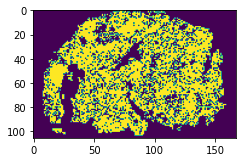

100%|██████████| 66/66 [00:00<00:00, 129.16it/s]


Some of the points were out of bound


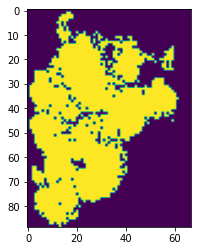

 15%|█▍        | 14/94 [00:00<00:00, 136.60it/s]

Some of the points were out of bound


100%|██████████| 66/66 [00:00<00:00, 129.44it/s]


Some of the points were out of bound


In [35]:
samples_id = [0,3]
factors_id = [1,3,5]

n_samples = len(samples_id)
n_factors = len(factors_id)
n_factors_bassis = 8

mask_expimm = []
scale = 3
for i in samples_id:
    exp_sample_list[i].data_to_grid(scale_factor=scale, probability=0.6)
    imm_sample_list[i].data_to_grid(scale_factor=scale, probability=0.6)
    t_exp = np.array([s for s in exp_sample_list[i].gene_grid.values()]).sum(0)
    t_imm = np.array([s for s in imm_sample_list[i].gene_grid.values()]).sum(0)
    
    mask_infisiable_expimm = (exp_sample_list[i].gene_grid['infeasible']/t_exp < 0.1) * \
                             (imm_sample_list[i].gene_grid['infeasible']/t_imm < 0.1)  
    plt.figure(figsize=(8,4))
    #plt.subplot(1,2,1)
    #plt.imshow(mask_infisiable.T[::-1,:])
    plt.subplot(1,2,2)
    plt.imshow(mask_infisiable_expimm.T[::-1,:])
    plt.show()
    #mask.append(mask_infisiable.flatten())
    mask_expimm.append(mask_infisiable_expimm.flatten())

# renaming inconsitent genes 
for i in samples_id:
    exp_sample_list[i].data_to_grid(scale_factor=scale, probability=0.6)
    imm_sample_list[i].data_to_grid(scale_factor=scale, probability=0.6)
    if 'Oct-04' in exp_sample_list[i].gene_grid.keys():
        exp_sample_list[i].gene_grid['OCT-4'] = exp_sample_list[i].gene_grid.pop('Oct-04')
        exp_sample_list[i].genes[np.where(exp_sample_list[i].genes == 'Oct-04')] = 'OCT-4'

    
imm_genes = np.concatenate([imm_sample_list[0].genes[:-4], np.array(['perforin'])])
exp_genes = exp_sample_list[0].genes[:-3]


n_imm_genes = len(imm_genes)
n_exp_genes = len(exp_genes)

subclone_proportions = [softmax(np.stack([samples_hierarchical_errosion[f'f_f_{i}_{s}'] for i in range(n_factors_bassis)], axis=2),axis=2).mean(axis=0) for s in samples_id]

#subclone_proportions_wtjoined = [subclone_proportions[s][:,:,:].copy() for s in range(n_samples)]
subclone_means = [np.zeros((subclone_proportions[s].shape[0], 8)) for s in range(n_samples)]
for s in range(n_samples):
    subclone_means[s][np.arange(subclone_proportions[s].shape[0]), np.argmax(subclone_proportions[s], axis=1)] = 1
    subclone_means[s][samples_hierarchical_errosion[f'lm_n_{samples_id[s]}'].mean(axis=0) < 5,:] = 0
    subclone_means[s] = subclone_means[s][:,factors_id]
    
#subcl_locations = []
#for s in range(n_samples):
#    subcl_locations.append([])
#    for i, f in enumerate(factors_id):
#        subcl_locations[s].append(softmax(subclone_proportions[s], axis=2)[:,:,f].mean(axis=0))
#    #    subcl_locations[s][i] = subcl_locations[s][i] > np.percentile(subcl_locations[s][i], 80)
#    #subcl_intersection = np.zeros(subcl_locations[s][0].shape) 
#    #for i in range(n_factors):
#    #    subcl_intersection += subcl_locations[s][i].astype(int)
#    #subcl_intersection = subcl_intersection > 1
#    #for i in range(n_factors):
#    #    subcl_locations[s][i] *= np.logical_not(subcl_intersection)
        

#subclone_means = [np.array(subcl_locations[s]).T for s in range(n_samples)] #[subclone_proportions_wtjoined[s].mean(axis=0) for s in range(n_samples)]
#subclone_vars = [subclone_proportions_wtjoined[s].var(axis=0) for s in range(n_samples)]








exp_iss_data = [np.transpose(np.array([exp_sample_list[i].gene_grid[k] for k in exp_genes]), [1,2,0]).reshape(-1, n_exp_genes) for i in samples_id]
imm_iss_data = [np.transpose(np.array([imm_sample_list[i].gene_grid[k] for k in imm_genes]), [1,2,0]).reshape(-1, n_imm_genes) for i in samples_id]

tiles_axes = [exp_sample_list[i].tile_axis for i in samples_id]

exp_cells_counts = [exp_sample_list[i].cell_grid.flatten() for i in samples_id]
imm_cells_counts = [imm_sample_list[i].cell_grid.flatten() for i in samples_id]
expimm_masks = [mask_expimm[i] for i in range(n_samples)]

sample_dims = [(int(tiles_axes[i][0][-1]+1), int(tiles_axes[i][1][-1]+1)) for i in range(n_samples)]
#n_factors = subclone_means[0].shape[-1] - 2
#n_factors = 7
#n_aug=1

n_aug= 0

sample_separate_flag = True


### Define and run the model

In [ ]:
with pm.Model() as model_exp_bi_prior:
    
    r_mu_exp = [pm.Gamma(f'r_mu_exp_{s}', mu=0.5, sigma=1, shape=(n_exp_genes, n_factors)) for s in range(n_samples)]
    r_mu_imm = [pm.Gamma(f'r_mu_imm_{s}', mu=0.5, sigma=1, shape=(n_imm_genes, n_factors)) for s in range(n_samples)]

    r_xi_exp = [pm.Gamma('r_xi_exp_{}'.format(s), mu=0.5, sigma=1, shape=n_exp_genes) for s in range(n_samples)]
    r_xi_imm = [pm.Gamma('r_xi_imm_{}'.format(s), mu=0.5, sigma=1, shape=n_imm_genes) for s in range(n_samples)]


    lm_n_exp = [pm.Gamma('lm_n_exp_{}'.format(s), mu=50, sigma=100, shape=len(exp_cells_counts[s])) for s in range(n_samples)]
    pois_n_exp = [pm.Poisson('n_exp_{}'.format(s), lm_n_exp[s], observed=exp_cells_counts[s]) for s in range(n_samples)]  
    lm_n_imm = [pm.Gamma('lm_n_imm_{}'.format(s), mu=50, sigma=100, shape=len(imm_cells_counts[s])) for s in range(n_samples)]
    pois_n_imm = [pm.Poisson('n_imm_{}'.format(s), lm_n_imm[s], observed=imm_cells_counts[s]) for s in range(n_samples)]  

    prior_proportions = [subclone_means[s] for s in range(n_samples)]
    
    
    F = [pm.Deterministic('F_{}'.format(s), theano.shared(prior_proportions[s])) for s in range(n_samples)] #[pm.Deterministic('F_{}'.format(s), tt.exp(F_pri[s] / 2) / tt.exp(F_pri[s] / 2).sum(axis=1)[:,None]) for s in range(n_samples)]
    
    theta_E_exp = [pm.Deterministic('theta_E_exp_{}'.format(s), tt.dot(F[s][:,:], r_mu_exp[s].T)) for s in range(n_samples)]
    theta_E_imm = [pm.Deterministic('theta_E_imm_{}'.format(s), tt.dot(F[s][:,:], r_mu_imm[s].T)) for s in range(n_samples)]
    lm_exp = [lm_n_exp[s][:, np.newaxis] * theta_E_exp[s] + r_xi_exp[s][None, :] for s in range(n_samples)]
    lm_imm = [lm_n_imm[s][:, np.newaxis] * theta_E_imm[s] + r_xi_imm[s][None, :] for s in range(n_samples)]

    o_exp = pm.Gamma('o_exp', mu=100, sd=10, shape=n_exp_genes)
    o_imm = pm.Gamma('o_imm', mu=100, sd=10, shape=n_imm_genes)

    expression_genes_exp = [pm.NegativeBinomial('exp_genes_{}'.format(s), mu = lm_exp[s][expimm_masks[s],:], alpha=o_exp, observed=exp_iss_data[s][expimm_masks[s],:]) for s in range(n_samples)]
    expression_genes_imm = [pm.NegativeBinomial('imm_genes_{}'.format(s), mu = lm_imm[s][expimm_masks[s],:], alpha=o_imm, observed=imm_iss_data[s][expimm_masks[s],:]) for s in range(n_samples)]


In [ ]:
np.random.seed(1234) 
pm.set_tt_rng(1234)

with model_exp_bi_prior :
    advi = pm.ADVI()
    approx_exp_bi_prior = advi.fit(n=15000, obj_optimizer=pm.adam(learning_rate=0.01))
    


In [36]:
#plt.plot(approx_exp_bi_prior.hist[1000:])
with open('../pymc_model/data/2805_approx_greenVSyellow_05-03.pkl', 'rb') as file:
    #pkl.dump(approx_exp_bi_prior, file)
    approx_exp_bi_prior = pkl.load(file)

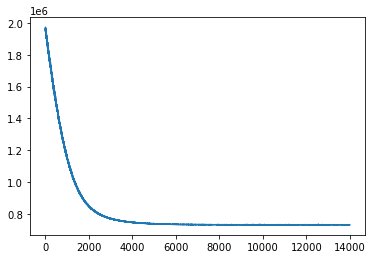

In [37]:
plt.plot(approx_exp_bi_prior.hist[1000:])
samples_exp_bi_prior = approx_exp_bi_prior.sample(300)


### Extract inferred parameters 

In [38]:
np.random.seed(192)
means = approx_exp_bi_prior.bij.rmap(approx_exp_bi_prior.mean.eval())
rho = approx_exp_bi_prior.rho.eval()
sds = approx_exp_bi_prior.bij.rmap(np.log(1 + np.exp(rho)))

if sample_separate_flag:
    E_data_mean = np.concatenate([np.stack([means[f'r_mu_exp_{s}_log__'] for s in range(n_samples)], axis=1),
                                  np.stack([means[f'r_mu_imm_{s}_log__'] for s in range(n_samples)], axis=1)], axis=0)
    E_data_sds = np.concatenate([np.stack([sds[f'r_mu_exp_{s}_log__'] for s in range(n_samples)], axis=1),
                                  np.stack([sds[f'r_mu_imm_{s}_log__'] for s in range(n_samples)], axis=1)], axis=0)

E_data = np.transpose(np.exp(np.random.normal(E_data_mean, E_data_sds, size=(100000, *E_data_mean.shape))), axes=(0,1,3,2))

E_names = np.concatenate([exp_genes, imm_genes])
E_pannel_from = np.array(['exp'] * n_exp_genes  + ['imm'] * n_imm_genes)
E_pannel_color = np.array(['orange'] * n_exp_genes  + ['skyblue'] * n_imm_genes)

exp_signal_counts = np.array([[(exp_iss_data[s][subclone_means[s][:,i] == 1]).sum(axis=0).astype(int) for i in range(3)] for s in range(2)]).T
imm_signal_counts = np.array([[(imm_iss_data[s][subclone_means[s][:,i] == 1]).sum(axis=0).astype(int) for i in range(3)] for s in range(2)]).T

exp_cell_counts = np.array([[(exp_cells_counts[s][subclone_means[s][:,i] == 1]).sum(axis=0).astype(int) for i in range(3)] for s in range(2)]).T
imm_cell_counts = np.array([[(imm_cells_counts[s][subclone_means[s][:,i] == 1]).sum(axis=0).astype(int) for i in range(3)] for s in range(2)]).T

signal_counts = np.concatenate([exp_signal_counts, imm_signal_counts], axis=0)
nucl = np.concatenate([exp_cell_counts[None,:,:], imm_cell_counts[None,:,:]], axis=0)
tiles = np.array([subclone_means[i].sum(axis=0) for i in range(2)])
signal_counts_per_nucl = np.concatenate([exp_signal_counts/exp_cell_counts[None,:,:], imm_signal_counts/imm_cell_counts[None,:,:]], axis=0)
cell_counts = np.stack([exp_cell_counts, imm_cell_counts])


#chagne gene names in plots
gene_name2good = {'PTPRC':'CD45', 'CD274':'PD-L1', 'Ki-67':'MKI67'}
for k in gene_name2good.keys():
    E_names[np.where(E_names == k)] = gene_name2good[k]

#remove PTPRC_trans5

ptprc_trans5_loc = np.where(E_names == 'PTPRC_trans5')[0]

E_data = np.delete(E_data, ptprc_trans5_loc, axis=1)
E_names = np.delete(E_names, ptprc_trans5_loc)
E_pannel_from = np.delete(E_pannel_from, ptprc_trans5_loc)
E_pannel_color = np.delete(E_pannel_color, ptprc_trans5_loc)
signal_counts = np.delete(signal_counts, ptprc_trans5_loc, axis=0)
signal_counts_per_nucl = np.delete(signal_counts_per_nucl, ptprc_trans5_loc, axis=0)

In [39]:
sample_names = ['d', 'l']
data_dict = {sample_names[i]:E_data[:,:,:,n] for i, n in enumerate([0, 1])}
# look at d and l 
data_dict = {k:data_dict[k] for k in ['d', 'l']}

In [40]:
dat = [data_dict[k][:,:,2] / data_dict[k][:,:,0] for k in ['d', 'l']]
p_vals = np.array([pplr(data_dict[k][:,:,2], data_dict[k][:,:,0], 1) for k in  ['d', 'l']])
dat = np.array([np.log10(dat[i]) for i, k in enumerate( ['d', 'l'])])

subclone_progression_comparison = add_comparison_to_dict(subclone_progression_comparison,
                                                         comp_name = 'O_d vs G_d',
                                                         dat = dat[0,:,:],
                                                         p_val = p_vals[0,:],
                                                         gene_names = E_names,
                                                         panel = E_pannel_from)

subclone_progression_comparison = add_comparison_to_dict(subclone_progression_comparison,
                                                         comp_name = 'O_l vs G_l',
                                                         dat = dat[1,:,:],
                                                         p_val = p_vals[1,:],
                                                         gene_names = E_names,
                                                         panel = E_pannel_from)

dat = [data_dict[k][:,:,0] / data_dict[k][:,:,1] for k in ['d', 'l']]
p_vals = np.array([pplr(data_dict[k][:,:,1], data_dict[k][:,:,0], 1) for k in  ['d', 'l']])
dat = np.array([np.log10(dat[i]) for i, k in enumerate( ['d', 'l'])])

subclone_progression_comparison = add_comparison_to_dict(subclone_progression_comparison,
                                                         comp_name = 'G_d vs B_d',
                                                         dat = dat[0,:,:],
                                                         p_val = p_vals[0,:],
                                                         gene_names = E_names,
                                                         panel = E_pannel_from)

dat = [data_dict[k][:,:,2] / data_dict[k][:,:,1] for k in ['d', 'l']]
p_vals = np.array([pplr(data_dict[k][:,:,2], data_dict[k][:,:,1], 1) for k in  ['d', 'l']])
dat = np.array([np.log10(dat[i]) for i, k in enumerate( ['d', 'l'])])

subclone_progression_comparison = add_comparison_to_dict(subclone_progression_comparison,
                                                         comp_name = 'O_d vs B_d',
                                                         dat = dat[0,:,:],
                                                         p_val = p_vals[0,:],
                                                         gene_names = E_names,
                                                         panel = E_pannel_from)



In [41]:
subclone_progression_absolute['DCIS-G-d'] = data_dict['d'][:,:,0]
subclone_progression_absolute['DCIS-B-d'] = data_dict['d'][:,:,1]
subclone_progression_absolute['DCIS-O-d'] = data_dict['d'][:,:,2]
subclone_progression_absolute['DCIS-G-l'] = data_dict['l'][:,:,0]
subclone_progression_absolute['DCIS-B-l'] = data_dict['l'][:,:,1]
subclone_progression_absolute['DCIS-O-l'] = data_dict['l'][:,:,2]

subclone_counts_data['DCIS-G-d'] = signal_counts[:,0,0]
subclone_counts_data['DCIS-B-d'] = signal_counts[:,1,0]
subclone_counts_data['DCIS-O-d'] = signal_counts[:,2,0]
subclone_counts_data['DCIS-G-l'] = signal_counts[:,0,1]
subclone_counts_data['DCIS-B-l'] = signal_counts[:,1,1]
subclone_counts_data['DCIS-O-l'] = signal_counts[:,2,1]

subclone_countspernucl_data['DCIS-G-d'] = signal_counts_per_nucl[:,0,0]
subclone_countspernucl_data['DCIS-B-d'] = signal_counts_per_nucl[:,1,0]
subclone_countspernucl_data['DCIS-O-d'] = signal_counts_per_nucl[:,2,0]
subclone_countspernucl_data['DCIS-G-l'] = signal_counts_per_nucl[:,0,1]
subclone_countspernucl_data['DCIS-B-l'] = signal_counts_per_nucl[:,1,1]
subclone_countspernucl_data['DCIS-O-l'] = signal_counts_per_nucl[:,2,1]

subclone_tiles['DCIS-G-d'] = tiles[0,0]
subclone_tiles['DCIS-B-d'] = tiles[0,1]
subclone_tiles['DCIS-O-d'] = tiles[0,2]
subclone_tiles['DCIS-G-l'] = tiles[0,0]
subclone_tiles['DCIS-B-l'] = tiles[1,1]
subclone_tiles['DCIS-O-l'] = tiles[1,2]

subclone_nuclei['DCIS-G-d'] = nucl[:,0,0]
subclone_nuclei['DCIS-B-d'] = nucl[:,1,0]
subclone_nuclei['DCIS-O-d'] = nucl[:,2,0]
subclone_nuclei['DCIS-G-l'] = nucl[:,0,1]
subclone_nuclei['DCIS-B-l'] = nucl[:,1,1]
subclone_nuclei['DCIS-O-l'] = nucl[:,2,1]

## Differential expression figures
### Set data in dataframes  

In [42]:
subclones = np.array(list(subclone_progression_absolute.keys()))
mean_val = np.array([np.percentile(subclone_progression_absolute[s], 50, axis=0) for s in subclones])
low_val = np.array([np.percentile(subclone_progression_absolute[s], 2.5, axis=0) for s in subclones])
high_val = np.array([np.percentile(subclone_progression_absolute[s], 97.5, axis=0) for s in subclones])
panel_names = E_pannel_from
gene_names = E_names

In [43]:
def calc_exp_difference(data, subclones, gene_to_process=None, th=0.01, m_mht=None):
    if gene_to_process is None:
        data_prepared = np.transpose(np.array([data[k] for k in subclones]), [1,0,2])
    else:
        data_prepared = np.transpose(np.array([data[k][:,gene_to_process] for k in subclones]), [1,0,2])
        
    pval = np.ones((data_prepared.shape[1], data_prepared.shape[1], data_prepared.shape[2]))
    direction = np.ones((data_prepared.shape[1], data_prepared.shape[1], data_prepared.shape[2]))
    for i in range(data_prepared.shape[1]):
        for j in range(data_prepared.shape[1]):
            pval[i,j,:] = pplr(data_prepared[:,i,:], data_prepared[:,j,:],by=1)
            direction[i,j,:] = data_prepared[:,i,:].mean(axis=0) - data_prepared[:,j,:].mean(axis=0)
            
    if not m_mht is None:
        pval = bonferonni(pval, m=m_mht)
    is_different = pval
    is_up = (direction > 0)*2 -1 
    
    return is_up * is_different

In [44]:
# proportion of times
mats = []
grads = []
grads_no_mht = []

for pan_id in range(2):
        y_order = [0,1,8,6,3,4,7,2,5,9,11]

        x_sub = np.where(panel_names == ['imm', 'exp'][pan_id])[0]
        mat = np.array(mean_val)[y_order, :][:,x_sub]
        mat = mat#/mat.max(axis=0, keepdims=True)#)/ (np.array(mean_val)[y_order,:][:, x_sub]).sum(axis=0, keepdims=True)

        grads.append(calc_exp_difference(subclone_progression_absolute, subclones[y_order], gene_to_process=x_sub, th=0.01, m_mht=mat.shape[1]*2))
        grads_no_mht.append(calc_exp_difference(subclone_progression_absolute, subclones[y_order], gene_to_process=x_sub, th=0.01, m_mht=None))
        mats.append(mat)

In [45]:
comps = [(0,1), (1,2), (0,2), (2,3), (4,5), (5,6), (4,6), (10,9)]
for pair in comps:
    print(subclones[y_order][pair[0]], subclones[y_order][pair[1]])

INV-R-a DCIS-R-a
DCIS-R-a DCIS-O-d
INV-R-a DCIS-O-d
DCIS-O-d DCIS-G-d
INV-P-c DCIS-P-c
DCIS-P-c DCIS-B-d
INV-P-c DCIS-B-d
DCIS-O-l DCIS-G-l


In [46]:
df_mat = []
df_grad = []
for pan_id in range(2):
        y_order = [0,1,8,6,3,4,7,2,5,9,11]

        x_sub = np.where(panel_names == ['imm', 'exp'][pan_id])[0]
        grads = calc_exp_difference(subclone_progression_absolute, subclones[y_order], gene_to_process=x_sub, th=0.01, m_mht=mat.shape[1]*2)

        
        mat = np.array(mean_val)[y_order, :][:,x_sub]
        mat = mat#/mat.max(axis=0, keepdims=True)#)/ (np.array(mean_val)[y_order,:][:, x_sub]).sum(axis=0, keepdims=True)


        yticklabels = subclones[y_order]
        xticklabels = gene_names[x_sub]
        
        subcl4df_mat = []
        gene4df_mat = []
        mean_val4df_mat = []
        std_val4df_mat = []

        subcl_from4df_grad = []
        subcl_to4df_grad = [] 
        gene4df_grad = []
        grad4df_grad = []

        for sub_i in range(mat.shape[0]):
            for ge_i in range(mat.shape[1]):
                subcl4df_mat.append(yticklabels[sub_i])
                gene4df_mat.append(xticklabels[ge_i])
                mean_val4df_mat.append(mat[sub_i, ge_i])

        for sub_i in range(mat.shape[0]):
            for sub_j in range(mat.shape[0]):
                for ge_i in range(mat.shape[1]):
                    subcl_from4df_grad.append(yticklabels[sub_i])
                    subcl_to4df_grad.append(yticklabels[sub_j])
                    gene4df_grad.append(xticklabels[ge_i])
                    grad4df_grad.append(grads[sub_i, sub_j, ge_i])

        df_mat.append(pd.DataFrame({'subclone':subcl4df_mat, 'gene':gene4df_mat ,'mean_val': mean_val4df_mat}))
        df_grad.append(pd.DataFrame({'subclone_from':subcl_from4df_grad, 'subclone_to':subcl_to4df_grad, 'gene':gene4df_grad ,'direction': grad4df_grad}))

#### Set functional colours 

In [47]:
exp_gene_groups = pd.read_csv('../pymc_model/data/exp_genes_groups.csv')
imm_gene_groups = pd.read_csv('../pymc_model/data/imm_genes_group.csv')
OncotypeDX = exp_gene_groups[(exp_gene_groups.OncotypeDX == 'down') | (exp_gene_groups.OncotypeDX == 'up')]

imm_gene2type = {imm_gene_groups['ISS target name '].values[i]:imm_gene_groups['Group'].values[i] for i in range(imm_gene_groups.shape[0])}
exp_gene2type = {exp_gene_groups['ISS Target name'].values[i]:exp_gene_groups['Group'].values[i] for i in range(exp_gene_groups.shape[0])}
exp_gene2oncotype = {OncotypeDX['ISS Target name'].values[i]:OncotypeDX['OncotypeDX'].values[i] for i in range(OncotypeDX.shape[0])}
exp_gene2oncotype['HER2'] = exp_gene2oncotype.pop('ERBB2')

def gene2funcgroup(gene, pannel):
    if pannel == 'imm':
        try:
            return imm_gene2type[gene]
        except KeyError:
            return None
    elif  pannel == 'exp':
        try:
            return exp_gene2type[gene]
        except KeyError:
            return None
    else:
        raise KeyError('either exp or imm')

def gene2funccolor(gene, pannel, default_color='black'):
    colors = {'Bcell':'yellow',
              'CD8_Tcell':'steelblue',
              'CD8_naive':'lightskyblue', 
          #'CD8_cytotoxic':'magenta',#, 'CD8_naive':'forestgreen', 
          #'DC': 'purple',
          'fibroblast':'gold','Fibroblast markers':'gold',
          #'hypoxia_angiogenesis':'red','Angiogenesis/growth factors':'red',
          #'immune_tolerance': 'skyblue',
          'NK':'forestgreen',
          #'macrophage':'dimgrey', 'Macrophage markers':'dimgrey',
          #'monocyte':'tomato',
          #'pan_immune_cell_marker':'black', 'Lymphocyte marker':'black',
          'proliferation': 'orangered', 'Proliferation':'violet', 'HER2':'violet',
          #'Tcell':'brown', 'Tcell_CD4':'brown',
          'Treg': 'darkviolet'}
          #'Stemness/differentiation': 'darkgreen'}
    
    
    group = gene2funcgroup(gene, pannel)
    try:
        return colors[group]
    except KeyError:
        return default_color

    
oncotypes = {'GRB7':'grb7' , 'HER2':'grb7',
             'ER':'er', 'PR':'er', 'BCL2':'er', 'SCUBE2':'er',
             'BIRC5':'proliferation', 'MKI67':'proliferation', 'MYBL2':'proliferation', 'CCNB1':'proliferation', 'STK15':'proliferation',
             'CTSL2': 'invasion', 'MMP11': 'invasion'}

def gene2oncocolor(gene, default_color='lightgrey'):
    color={'grb7': 'forestgreen', 'er':'dodgerblue', 'proliferation':'darkorange', 'invasion':'red'}
    try:
        oncotype = oncotypes[gene]
        return color[oncotype]
    except KeyError:
        return default_color
    

### Differential expression samples PD9694a and PD9694c

<b>Fig. 3. Temporal ordering of genetic, transcriptional and immunological changes during the
development of invasive cancer</b>

<b>(E)</b> A dot plot showing the relative expression of the same genes
from (D) at the different progression stages in the 2 lineages. Dot area = (transcript/nucleus)
divided by maximum value for each gene. Boxplots report transcripts/ nucleus (left) for genes
shown and fold change between indicated comparisons (right). For all boxplots we report median,
lower and upper quartiles (box) and 5-95 percentiles (whiskers). Expression per clone was defined
on 136 - 3262 tiles, see Table S6 for details.

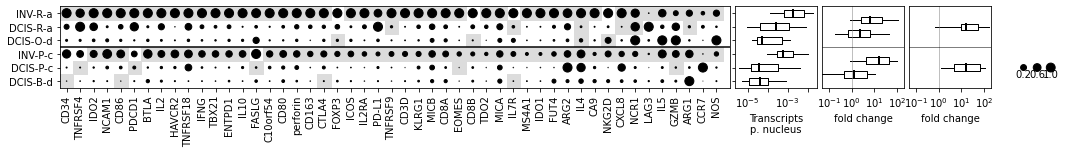

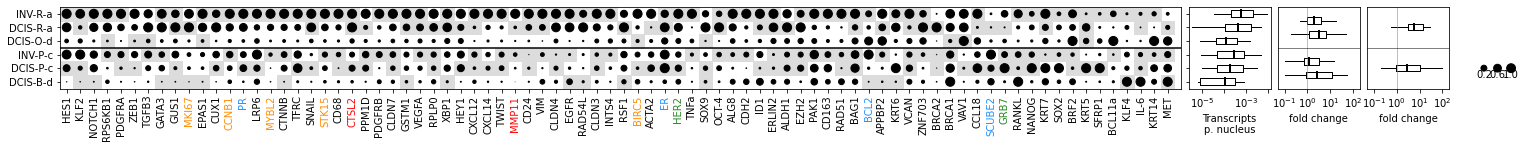

In [48]:
mpl.rcParams['pdf.fonttype'] = 42
for ind, i in enumerate(['imm','exp']):
    f = df_mat[ind].set_index(['subclone', 'gene']).loc[:,"mean_val"].unstack()
    g = df_grad[ind].set_index(['subclone_from', 'subclone_to', 'gene']).loc[:,"direction"].unstack()
    v = ['DCIS-B-d','DCIS-P-c','INV-P-c','DCIS-O-d','DCIS-R-a','INV-R-a']

    g_sub = g[g.index.isin([(v[0],v[2]), (v[3],v[5])] )]
    w = (g_sub.abs() > 0.01).values.sum(axis=0) > 0
    #print(w.sum()/f.shape[1])

    y = f.loc[v,w]
    x = y.values
    m,n = x.shape
    fig, ax = plt.subplots(1,5, gridspec_kw={'width_ratios':(n,6,6,6,6), 'wspace':0.025},figsize=((n+6+6+6+6)/4,m/4), sharey=True)
    #ax=ax[::-1]
    foo = x
    foo = foo/foo.max(axis=0, keepdims=True)
    
    o = (-2*foo[-1,:] - 2*foo[2,:]-foo[-2,:] +foo[1,:]+ 2*foo[0,:]+2*foo[3,:]).argsort()
    
    a = np.where(g.loc[:,w].iloc[[1,4],o]!=0)
    for j,k in zip(a[0],a[1]):
        ax[0].plot([k,k],[j,j+1], color='k', ls="")
    a = np.where(g.loc[:,w].iloc[[2,5],o]!=0)
    for j,k in zip(a[0],a[1]):
        ax[0].plot([k,k],[j+3,j+4], color='k', ls="")
    
    foo = foo[:,o]
    foo_max = x
    foo_max[:3] = foo_max[:3]/foo_max[:3].max(axis=0, keepdims=True)
    foo_max[3:] = foo_max[3:]/foo_max[3:].max(axis=0, keepdims=True)
    color = (foo_max >= 0.7).astype(int)
    xy = np.meshgrid(np.arange(n),np.arange(m))
   
    R = np.sqrt(foo)/3
    circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, xy[0].flatten(), xy[1].flatten())]
    col = PatchCollection(circles, color=np.array(['k', 'k'])[color.flatten()])
    
    rects=[]
    for y_ar in range(color.shape[0]):
        for x_ar in range(color.shape[1]):
            if color[y_ar, x_ar] != 0:
                rects.append(plt.Rectangle((x_ar-0.5, y_ar-0.5), 1,1))
                #rects.append(plt.Rectangle((x_ar-0.5, y_ar-0.5), 1,1))
    rectcol =  PatchCollection(rects, color='gainsboro')
    ax[0].add_collection(rectcol)
    ax[0].add_collection(col)
    ax[0].axhline(2.5, color='k')
    ax[0].set_xlim((-.5,n))
    _=ax[0].set_xticks(np.arange(n))
    _=ax[0].set_xticklabels(  y.columns[o], rotation=90)
    _=ax[0].set_yticks(np.arange(m))
    _=ax[0].set_yticklabels( y.index)
    
    y = f.loc[v,w]#e.loc[v,i]
    x = y.values
    x = x #/ x.max(0)[np.newaxis,:]
    
    _=ax[1].boxplot(x.T, positions=np.arange(m),
                    vert=False, whis=(5,95), sym="", medianprops={'color':"k", 'linewidth':2},
                    boxprops={'color':"k"},whiskerprops={'color':"k"}, showcaps=False)


    ax[1].set_xscale('log')
    ax[1].set_xlabel('Transcripts\np. nucleus')
    #ax[1].set_xlim((1e-6,2e-1))
    ax[1].set_xticks([1e-5, 1e-4,1e-3, 1e-2])#, 1e-1])
    ax[1].set_xticklabels(["$10^{-5}$", "","$10^{-3}$", ""])#, "$10^{-1}$"])
    
    
    subcl4df_mat = []
    gene4df_mat = []
    mean_val4df_mat = []

    for sub_i in range(foo.shape[0]):
        for ge_i in range(foo.shape[1]):
            subcl4df_mat.append(y.index[sub_i])
            gene4df_mat.append(y.columns[ge_i])
            mean_val4df_mat.append(foo[sub_i, ge_i])

    
    _=ax[2].boxplot([x[1,:]/x[0,:], x[2,:]/x[1,:], x[4,:]/x[3,:],x[5,:]/x[4,:]], positions=np.array([0,1,3,4])+0.5,
                    vert=False, whis=(5,95), sym="", medianprops={'color':"k", 'linewidth':2},
                    boxprops={'color':"k"},whiskerprops={'color':"k"}, showcaps=False)
    #ax[1].grid(axis='x')
    ax[2].set_xscale('log')
    ax[2].set_xlabel('fold change')
    ax[2].set_xlim(5e-2,2e2)
    ax[2].axvline(1, color='grey', linewidth=0.5)
    ax[2].get_yaxis().set_visible(False)
    ax[2].set_xticks([1e-1, 1, 1e1, 1e2])
    ax[2].axhline(2.5, color='k', linewidth=0.5)
    
    
    _=ax[3].boxplot([x[2,:]/x[0,:],x[5,:]/x[3,:]], positions=np.array([1,4]),
                    vert=False, whis=(5,95), sym="", medianprops={'color':"k", 'linewidth':2},
                    boxprops={'color':"k"},whiskerprops={'color':"k"}, showcaps=False)
    #ax[1].grid(axis='x')
    ax[3].set_xscale('log')
    ax[3].set_xlabel('fold change')
    ax[3].set_xlim(5e-2,2e2)
    ax[3].axvline(1, color='grey', linewidth=0.5)
    ax[3].get_yaxis().set_visible(False)
    ax[3].set_xticks([1e-1, 1, 1e1, 1e2])
    ax[3].axhline(2.5, color='k', linewidth=0.5)
    
    ref_s = np.array([0.2, 0.6, 1])
    x_ref = np.arange(len(ref_s))
    y_ref = np.array([1] * len(ref_s))
    R_ref = np.sqrt(ref_s)/3

    circles = [plt.Circle((j,i), radius=np.sqrt(r/np.pi)) for r, j, i in zip(R_ref.flat, x_ref.flat, y_ref.flat)]
    col = PatchCollection(circles, color='black')
    ax[4].add_collection(col)
    for j in range(len(ref_s)):
        ax[4].text(x_ref[j], y_ref[j]-0.5, ref_s[j], ha='center', va='center')                       
    ax[4].set_aspect('equal')
    ax[4].set_xlim(-0.5, 3-0.5)
    ax[4].axis('off')
    
    _=ax[0].set_yticks(np.arange(m))
    _=ax[0].set_yticklabels( y.index)
    ax[0].set_ylim(-0.5,m-0.5)
    
    for lab in ax[0].xaxis.get_ticklabels():
        lab.set_color(gene2oncocolor(lab.get_text(), default_color='k'))
    
    #plt.savefig(f'./images/blobs_{i}_composition_ordered_mht_shades.pdf')


<b>(D)</b> Boxplots report, for the genes upregulated between early DCIS and invasive cancer, 5 the extent to which this
is acquired within late DCIS. Significantly altered genes are defined as having PPLR after
Bonferroni correction < 0.01.

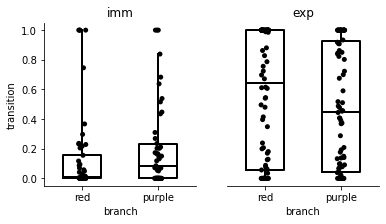

In [49]:
fig, axs = plt.subplots(1,2, figsize=(6,3),sharey=True)
for num, i in enumerate(['imm','exp']):
    f = df_mat[num].set_index(['subclone', 'gene']).loc[:,"mean_val"].unstack()
    g = df_grad[num].set_index(['subclone_from', 'subclone_to', 'gene']).loc[:,"direction"].unstack()
    v = ['DCIS-B-d','DCIS-P-c','INV-P-c','DCIS-O-d','DCIS-R-a','INV-R-a']
    g_sub = g[g.index.isin([(v[0],v[2]), (v[3],v[5])] )]
    w = (g_sub.abs() > 0.01).values.sum(axis=0) > 0
    #print(w.sum()/f.shape[1])

    y = f.loc[v,w]
    x = y.values
    m,n = x.shape
    foo = x

    foo[:3] = (foo[:3] - foo[:3].min(axis=0, keepdims=True))#/foo[:3].max(axis=0, keepdims=True)#[::-1,:]
    foo[3:] = (foo[3:] - foo[3:].min(axis=0, keepdims=True))#/foo[3:].max(axis=0, keepdims=True)#[::-1,:]
    foo[:3] = foo[:3]/foo[:3].max(axis=0, keepdims=True)#[::-1,:]
    foo[3:] = foo[3:]/foo[3:].max(axis=0, keepdims=True)#[::-1,:]
    df = pd.DataFrame({'transition':np.concatenate([foo[1], foo[4]]), 'branch':['red']*foo[1].shape[0] + ['purple']*foo[1].shape[0]})

    axs[num].set_title(i)
    box_palette = {'red':mcls.to_rgba('tomato'), 'purple':mcls.to_rgba('mediumorchid')}

    _=axs[num].boxplot([foo[1], foo[4]], positions=[0,1], widths=0.5, whis=(5,95), sym="", medianprops={'color':"k", 'linewidth':2},
                    boxprops={'color':"k", 'linewidth':2},whiskerprops={'color':"k",  'linewidth':2}, showcaps=False)

    np.random.seed(42)
    

    sns.stripplot(ax = axs[num], x="branch", y="transition", data=df, color=".0", jitter=0.05)

    axs[num].set_xlim(-0.5,1.5)

    
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].axes.get_yaxis().set_visible(False)
plt.show()

### Differential expression samples PD9694d and PD9694l
<b>Fig. S3. Case PD9694 clone specific characteristics</b>

<b>(D)</b> Dot plots and boxplots
reveal relative expression of ISS signals in Green (G) and Orange (Y) clones in samples PD9694d
and PD9694l. Expression is normalised by sample. Dot area = (transcript/nucleus) divided by
maximum value for each gene. Boxplots report transcripts/ nucleus (left) for genes shown and fold
change between indicated comparisons (right). For all boxplots we report median, lower and upper
quartiles (box) and 5-95 percentiles (whiskers). Expression per clone was defined on 162 - 3262
tiles, see Table S6 for details.

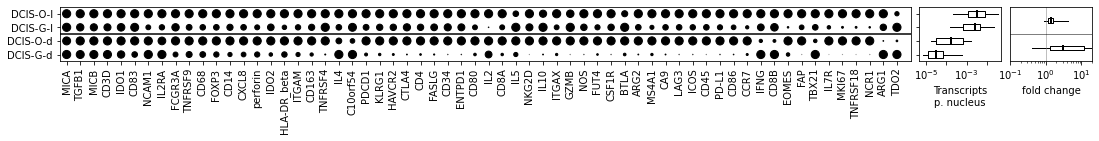

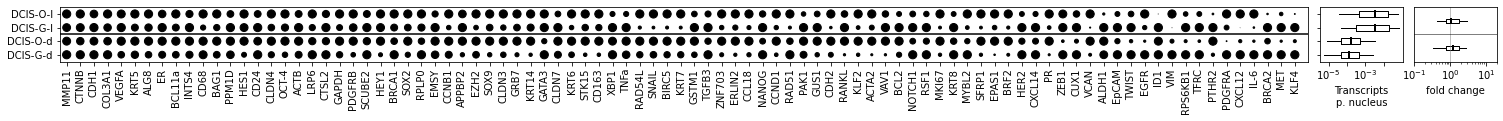

In [50]:
for ind, i in enumerate(['imm','exp']):
    f = df_mat[ind].set_index(['subclone', 'gene']).loc[:,"mean_val"].unstack()
    g = df_grad[ind].set_index(['subclone_from', 'subclone_to', 'gene']).loc[:,"direction"].unstack()
    v = ['DCIS-G-d', 'DCIS-O-d', 'DCIS-G-l', 'DCIS-O-l']
    g_sub = g[g.index.isin([(v[0],v[1]), (v[2],v[3])] )]
    w = g_sub.abs().sum() < 1e3
    y = f.loc[v,w]
    x = y.values
    m,n = x.shape
    
    fig, ax = plt.subplots(1,3, gridspec_kw={'width_ratios':(n,6,6), 'wspace':0.025},figsize=((n+6+6)/4,m/4), sharey=True)
    foo = x
    foo[:2] = foo[:2]/foo[:2].max(axis=0, keepdims=True)#[::-1,:]
    foo[2:] = foo[2:]/foo[2:].max(axis=0, keepdims=True)#[::-1,:]
    o = (-2*foo[1,:] - 2*foo[3,:]-foo[0,:] -foo[2,:]).argsort()
    
    a = np.where(g.loc[:,w].iloc[[1,4],o]!=0)
    for j,k in zip(a[0],a[1]):
        ax[0].plot([k,k],[j,j+1], color='k', ls="")
    a = np.where(g.loc[:,w].iloc[[2,5],o]!=0)
    for j,k in zip(a[0],a[1]):
        ax[0].plot([k,k],[j+3,j+4], color='k', ls="")
    
    foo = foo[:,o]
    xy = np.meshgrid(np.arange(n),np.arange(m))
    R = foo * 0.3
    circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, xy[0].flatten(), xy[1].flatten())]
    col = PatchCollection(circles, color='k')
    ax[0].add_collection(col)
    ax[0].axhline(1.5, color='k')
    ax[0].set_xlim((-.5,n))
    _=ax[0].set_xticks(np.arange(n))
    _=ax[0].set_xticklabels(  y.columns[o], rotation=90)
    _=ax[0].set_yticks(np.arange(m))
    _=ax[0].set_yticklabels( y.index)
    
    y = f.loc[v,w]
    x = y.values
    x = x 
    
    _=ax[1].boxplot(x.T, positions=np.arange(m),
                    vert=False, whis=(5,95), sym="", medianprops={'color':"k", 'linewidth':2},
                    boxprops={'color':"k"},whiskerprops={'color':"k"}, showcaps=False)
    #ax[1].grid(axis='x')
    #ax[1].grid(axis='x')
    ax[1].set_xscale('log')
    ax[1].set_xlabel('Transcripts\np. nucleus')
    #ax[1].set_xlim((1e-6,2e-1))
    ax[1].set_xticks([1e-5, 1e-4,1e-3, 1e-2])#, 1e-1])
    ax[1].set_xticklabels(["$10^{-5}$", "","$10^{-3}$", ""])#, "$10^{-1}$"])
    
    
    
    _=ax[2].boxplot([x[1,:]/x[0,:], x[3,:]/x[2,:]], positions=np.array([0,2])+0.5,
                    vert=False, whis=(5,95), sym="", medianprops={'color':"k", 'linewidth':2},
                    boxprops={'color':"k"},whiskerprops={'color':"k"}, showcaps=False)
    #ax[1].grid(axis='x')
    ax[2].set_xscale('log')
    ax[2].set_xlabel('fold change')
    ax[2].set_xlim(1e-1,2e1)
    ax[2].axvline(1, color='grey', linewidth=0.5)
    ax[2].get_yaxis().set_visible(False)
    ax[2].set_xticks([1e-1, 1, 1e1])
    ax[2].axhline(1.5, color='k', linewidth=0.5)
    #
    _=ax[0].set_yticks(np.arange(m))
    _=ax[0].set_yticklabels( y.index)
    ax[0].set_ylim(-0.5,3.5)


### Differential expression between DCIS-green and DCIS-orange
<b>Fig. 2. Histological, transcriptional and immunological differences between DCIS clones with
different fates</b>

<b>(F)</b> Barplots report fold changes in ISS gene panel expression
signals between orange (1,515 tiles) and green clone regions (2,583 tiles) (predominant clone
20 defines the location). Annotated genes have significant expression differences (probability of
positive log-ratio (PPLR) after Bonferroni correction < 0.01). Genes are ordered by combined
PPLR and direction of change (fine lines report CIs = 5 - 95%).

In [51]:
sample_names = ['d', 'l']
data_dict = {sample_names[i]:E_data[:,:,:,n] for i, n in enumerate([0, 1])}
# look at d and l 
data_dict = {k:data_dict[k] for k in ['d', 'l']}

dat = [data_dict[k][:,:,2] / data_dict[k][:,:,0] for k in ['d', 'l']]
p_vals = [pplr(data_dict[k][:,:,2], data_dict[k][:,:,0], 1) for k in ['d', 'l']]
dat = [np.log10(dat[i]) for i, k in enumerate(['d', 'l'])]

log_sum_pval = []
n_compar = 2
for i in range(len(p_vals[0])):
    vals_per_sample = np.array([dat[s].mean(axis=0)[i] for s in range(n_compar)])
    pvals_per_sample = np.array([p_vals[s][i] for s in range(n_compar)])
    if (np.sign(vals_per_sample) == np.sign(vals_per_sample)[0]).all():
        val = -2*(np.log(pvals_per_sample).sum())
    else:
        main_sign = np.sign(np.sum(vals_per_sample))
        ps = pvals_per_sample.copy()
        ps[np.sign(vals_per_sample) != main_sign] = 1-ps[np.sign(vals_per_sample) != main_sign]      
        val =-2*(np.log(ps).sum())
    log_sum_pval.append(val)

In [52]:
dat = data_dict['l'][:,:,2] / data_dict['l'][:,:,0]
dat = np.log10(dat)
p_vals = pplr(data_dict['l'][:,:,2], data_dict['l'][:,:,0], 1)
p_vals = bonferonni(p_vals, m=len(p_vals)*2)

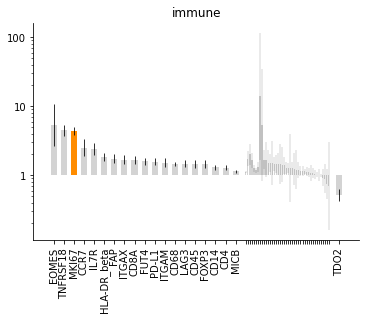

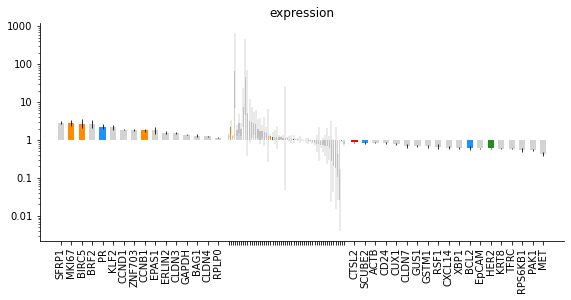

In [53]:
from matplotlib.ticker import MultipleLocator, FixedLocator, FuncFormatter
###### Locators for Y-axis
# set tickmarks at multiples of 1.
majorLocator = MultipleLocator(1.)
# create custom minor ticklabels at logarithmic positions
ra = np.array([ [n+(1.-np.log10(i))]  for n in range(-5,5) for i in [2,3,4,5,6,7,8,9][::-1]]).flatten()*-1.
minorLocator = FixedLocator(ra)
###### Formatter for Y-axis (chose any of the following two)
# show labels as powers of 10 (looks ugly)
majorFormatter= FuncFormatter(lambda x,p: "{:.4g}".format(10**x) ) 
# or using MathText (looks nice, but not conform to the rest of the layout)
#majorFormatter= FuncFormatter(lambda x,p: r"$10^{"+"{x:d}".format(x=int(x))+r"}$" ) 


percentiles_dat = [np.percentile(dat, pct, axis=0) for pct in [5,50,95]]

for pannel_id in range(2):
    subset = np.where(E_pannel_from == ['imm', 'exp'][pannel_id])[0]
    sub_percentiles_dat = [percentiles_dat[i][subset] for i in range(3)]
    p_vals_sub = p_vals[subset]
    ranks = -np.round(1/p_vals_sub * np.sign(sub_percentiles_dat[1]),2)
    order = []
    for r in np.unique(ranks):
        ranked_order = np.where(ranks == r)[0]
        magnitude_order = list(ranked_order[np.argsort((sub_percentiles_dat[1])[np.where(ranks == r)[0]])[::-1]]) 
        order += magnitude_order  
        
    boundaries = [0] + list(np.cumsum([len(np.where(ranks == r)[0]) for r in np.unique(ranks)]))
    boundaries_pval = np.array([0]+list([p_vals_sub[np.where(ranks == r)[0]][0] for r in np.unique(ranks)]))
    
    p_val_th = 0.01
    #color = [['darkgrey' if i < p_val_th else 'lightgrey' for i in p_vals[s][gene_filtered][subset][order]] for s in range(2)]
    gene_names = E_names[subset][order]
    if pannel_id == 1:
        #color = ['dimgrey', 'lightgrey']
        color = [gene2oncocolor(gene) for gene in gene_names]
    else:
        color = [gene2oncocolor(gene) for gene in gene_names]
    bpv = np.array(boundaries)[np.where(np.diff(boundaries_pval < p_val_th))[0]]
    xposdiff = np.ones(len(order))
    squeezed = 0.2
    
    if len(bpv) == 2:
        xposdiff[bpv[0]+1:bpv[1]] = squeezed
        xpos = np.cumsum(xposdiff)
        widths = xposdiff.copy()
        widths[bpv[0]] = squeezed
    elif len(bpv) == 1:
        if (boundaries_pval < p_val_th)[0]:
            xposdiff[bpv[0]+1:] = squeezed
            xpos = np.cumsum(xposdiff)
            widths = xposdiff.copy()
            widths[bpv[0]] = squeezed
        else:
            xposdiff[:bpv[0]-1] = squeezed
            xpos = np.cumsum(xposdiff)
            widths = xposdiff.copy()
    elif len(bpv) == 0:
        xpos = np.cumsum(xposdiff)
        widths = xposdiff.copy()
        
    
    for i in range(3):
        sub_percentiles_dat[i] = sub_percentiles_dat[i][order]
        
    
    plt.figure(figsize=(xpos[-1] * 0.2,4))
    plt.bar(xpos, sub_percentiles_dat[1], yerr=[np.abs(sub_percentiles_dat[0]-sub_percentiles_dat[1]),
                                                       np.abs(sub_percentiles_dat[2]-sub_percentiles_dat[1])], width=0.6*widths,
                       color=color, error_kw={'linewidth':widths*1, 'alpha':0.8})

    plt.gca().set_xticks(xpos)
    gene_names[widths == squeezed] = ''
    plt.gca().set_xticklabels(gene_names, rotation=90)
    plt.gca().set_title(['immune', 'expression'][pannel_id])
    plt.xlim(xpos[0]-2,xpos[-1]+2)
    #plt.ylim(-1.5, 1.5)
    plt.gca().yaxis.set_major_locator(majorLocator)
    plt.gca().yaxis.set_minor_locator(minorLocator)
    plt.gca().yaxis.set_major_formatter(majorFormatter)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    #plt.savefig(f'./images/2805_GreenVsOrange_{["imm", "exp"][pannel_id]}_bars_samples_L.pdf'.format(i))
plt.show()